In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


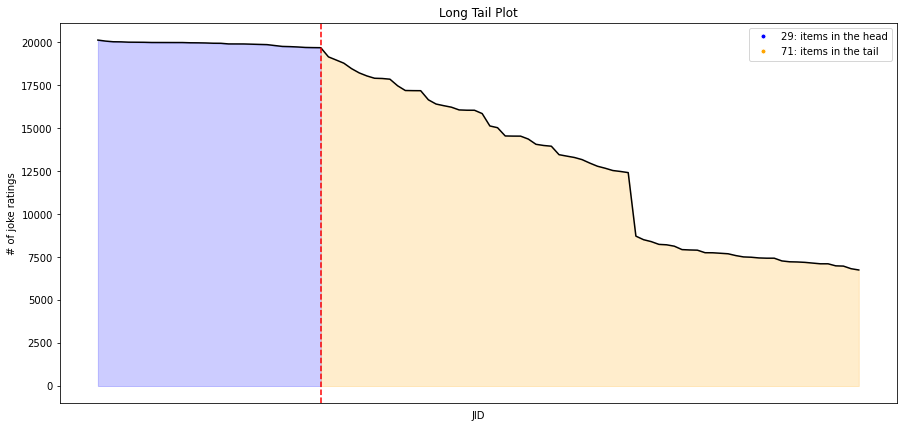

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [7]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [8]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [9]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

dict_keys(['catboost'])

In [10]:
with open('predictions_df_catboost_doc2vec.pkl', 'rb') as f:
    predictions_df_catboost_doc2vec = pickle.load(f)
    
predictions_df_catboost_doc2vec.keys()

dict_keys(['catboost_doc2vec'])

In [11]:
svd_df = predictions_df_surprise['svd']
knn_df = predictions_df_surprise['knn']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
catboost_doc2vec_df = predictions_df_catboost_doc2vec['catboost_doc2vec']
actual_df = predictions_df_surprise['actual']

In [12]:
frames = {'svd':svd_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
          'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df}

predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}
actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [13]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [14]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [15]:
pop = dict(df.JID.value_counts())

In [16]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [17]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
        for i, (key, value) in enumerate(predictions.items()):
            rank = {x: params[key] * (10-j) for j, x in enumerate(value[u])}

            for k, v in rank.items():
                if k in res:
                    res[k] += v
                else:
                    res[k] = v
                    
        for k in res:
            res[k] += joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])
        
    return result

In [18]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip * 4, map1 * 2, map10 * 2])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'sum', round(sm, 3))
    return sm

In [19]:
def objective(trial):    
    
    params = {'svd': trial.suggest_float(name='svd', low=-2, high=2, step=0.1), 
              'lfm_cos': trial.suggest_float(name='lfm_cos', low=-2, high=2, step=0.1), 
              'nn': trial.suggest_float(name='nn', low=-2, high=2, step=0.1),
              'knn': trial.suggest_float(name='knn', low=-2, high=2, step=0.1), 
              'catboost_doc2vec': trial.suggest_float(name='catboost_doc2vec', low=-2, high=2, step=0.1),
              'quality': trial.suggest_float(name='quality', low=-2, high=2, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-2, high=2, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)


[I 2023-05-06 20:33:50,198] A new study created in memory with name: no-name-c38e28ad-1695-48d2-913e-b613828f9ba7
[I 2023-05-06 20:33:52,566] Trial 0 finished with value: 4.052334947534382 and parameters: {'svd': -0.7999999999999998, 'lfm_cos': -0.5999999999999999, 'nn': 1.6, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.20000000000000018, 'volume': 1.0}. Best is trial 0 with value: 4.052334947534382.


time 2.364 cat_cov 71.0 cov 100.0 nov 0.749 ser 0.092 m1 0.243 m10 0.37 sum 4.052


[I 2023-05-06 20:33:55,237] Trial 1 finished with value: 5.042186673317469 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.0, 'volume': -0.2999999999999998}. Best is trial 1 with value: 5.042186673317469.


time 2.667 cat_cov 100.0 cov 100.0 nov 0.904 ser 0.23 m1 0.236 m10 0.372 sum 5.042


[I 2023-05-06 20:33:57,698] Trial 2 finished with value: 4.311564058806889 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': -0.09999999999999987, 'knn': -2.0, 'catboost_doc2vec': 1.9000000000000004, 'quality': -1.7, 'volume': -1.7}. Best is trial 1 with value: 5.042186673317469.


time 2.458 cat_cov 96.0 cov 100.0 nov 0.867 ser 0.176 m1 0.13 m10 0.261 sum 4.312


[I 2023-05-06 20:34:00,286] Trial 3 finished with value: 4.837313337107112 and parameters: {'svd': -1.0, 'lfm_cos': 1.4000000000000004, 'nn': 0.40000000000000036, 'knn': 1.8000000000000003, 'catboost_doc2vec': -1.1, 'quality': 0.0, 'volume': -1.0}. Best is trial 1 with value: 5.042186673317469.


time 2.582 cat_cov 98.0 cov 100.0 nov 0.776 ser 0.155 m1 0.302 m10 0.429 sum 4.837


[I 2023-05-06 20:34:02,846] Trial 4 finished with value: 4.523942945519392 and parameters: {'svd': -1.6, 'lfm_cos': 0.40000000000000036, 'nn': 1.6, 'knn': 1.2000000000000002, 'catboost_doc2vec': -1.7, 'quality': 1.4000000000000004, 'volume': 1.6}. Best is trial 1 with value: 5.042186673317469.


time 2.557 cat_cov 91.0 cov 100.0 nov 0.723 ser 0.108 m1 0.284 m10 0.446 sum 4.524


[I 2023-05-06 20:34:05,312] Trial 5 finished with value: 4.740794643570313 and parameters: {'svd': 0.0, 'lfm_cos': 1.2000000000000002, 'nn': 1.4000000000000004, 'knn': 1.2000000000000002, 'catboost_doc2vec': 1.2000000000000002, 'quality': 0.40000000000000036, 'volume': -1.2}. Best is trial 1 with value: 5.042186673317469.


time 2.463 cat_cov 84.0 cov 100.0 nov 0.709 ser 0.116 m1 0.374 m10 0.49 sum 4.741


[I 2023-05-06 20:34:07,829] Trial 6 finished with value: 4.913777319938578 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 1.6, 'nn': 1.5, 'knn': 1.6, 'catboost_doc2vec': 1.0, 'quality': 0.40000000000000036, 'volume': -1.4}. Best is trial 1 with value: 5.042186673317469.


time 2.514 cat_cov 97.0 cov 100.0 nov 0.699 ser 0.129 m1 0.376 m10 0.489 sum 4.914


[I 2023-05-06 20:34:10,124] Trial 7 finished with value: 3.928374672536222 and parameters: {'svd': -0.7, 'lfm_cos': -1.6, 'nn': -0.5999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.1, 'volume': 0.20000000000000018}. Best is trial 1 with value: 5.042186673317469.


time 2.291 cat_cov 89.0 cov 100.0 nov 0.849 ser 0.093 m1 0.148 m10 0.259 sum 3.928


[I 2023-05-06 20:34:12,589] Trial 8 finished with value: 4.192048422639434 and parameters: {'svd': -1.6, 'lfm_cos': -1.2, 'nn': -1.7, 'knn': -1.6, 'catboost_doc2vec': -0.8999999999999999, 'quality': 1.8000000000000003, 'volume': -0.3999999999999999}. Best is trial 1 with value: 5.042186673317469.


time 2.462 cat_cov 99.0 cov 100.0 nov 0.903 ser 0.143 m1 0.111 m10 0.253 sum 4.192


[I 2023-05-06 20:34:15,011] Trial 9 finished with value: 4.933454469500786 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.5, 'nn': -1.0, 'knn': -1.2, 'catboost_doc2vec': -1.1, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 1 with value: 5.042186673317469.


time 2.416 cat_cov 99.0 cov 100.0 nov 0.954 ser 0.175 m1 0.257 m10 0.389 sum 4.933


[I 2023-05-06 20:34:17,490] Trial 10 finished with value: 5.134322931806367 and parameters: {'svd': 2.0, 'lfm_cos': 0.5, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.7999999999999998, 'volume': 0.30000000000000027}. Best is trial 10 with value: 5.134322931806367.


time 2.461 cat_cov 100.0 cov 100.0 nov 0.895 ser 0.188 m1 0.308 m10 0.435 sum 5.134


[I 2023-05-06 20:34:19,982] Trial 11 finished with value: 5.130455725930402 and parameters: {'svd': 2.0, 'lfm_cos': 0.5, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.7999999999999998, 'volume': 0.20000000000000018}. Best is trial 10 with value: 5.134322931806367.


time 2.475 cat_cov 100.0 cov 100.0 nov 0.892 ser 0.185 m1 0.31 m10 0.438 sum 5.13


[I 2023-05-06 20:34:22,440] Trial 12 finished with value: 5.094522921879744 and parameters: {'svd': 2.0, 'lfm_cos': 0.5, 'nn': -1.2999999999999998, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.7999999999999998, 'volume': 0.5}. Best is trial 10 with value: 5.134322931806367.


time 2.441 cat_cov 100.0 cov 100.0 nov 0.875 ser 0.177 m1 0.313 m10 0.444 sum 5.095


[I 2023-05-06 20:34:24,919] Trial 13 finished with value: 4.898379391161648 and parameters: {'svd': 2.0, 'lfm_cos': 0.6000000000000001, 'nn': -1.2, 'knn': -0.5, 'catboost_doc2vec': 0.8000000000000003, 'quality': -0.7999999999999998, 'volume': 0.7000000000000002}. Best is trial 10 with value: 5.134322931806367.


time 2.46 cat_cov 95.0 cov 100.0 nov 0.859 ser 0.151 m1 0.313 m10 0.431 sum 4.898


[I 2023-05-06 20:34:27,323] Trial 14 finished with value: 4.995606040951088 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.5, 'quality': -0.7999999999999998, 'volume': 1.1}. Best is trial 10 with value: 5.134322931806367.


time 2.386 cat_cov 100.0 cov 100.0 nov 0.919 ser 0.153 m1 0.299 m10 0.433 sum 4.996


[I 2023-05-06 20:34:29,795] Trial 15 finished with value: 5.181755126972791 and parameters: {'svd': 1.5, 'lfm_cos': 0.9000000000000004, 'nn': -0.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.3999999999999999, 'volume': -0.5999999999999999}. Best is trial 15 with value: 5.181755126972791.


time 2.454 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.161 m1 0.379 m10 0.489 sum 5.182


[I 2023-05-06 20:34:32,201] Trial 16 finished with value: 4.62513908439774 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.0, 'nn': 0.5, 'knn': 0.5, 'catboost_doc2vec': 1.7000000000000002, 'quality': -0.2999999999999998, 'volume': -0.5999999999999999}. Best is trial 15 with value: 5.181755126972791.


time 2.389 cat_cov 73.0 cov 100.0 nov 0.746 ser 0.116 m1 0.372 m10 0.47 sum 4.625


[I 2023-05-06 20:34:34,616] Trial 17 finished with value: 3.806277954455065 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999987, 'nn': -0.3999999999999999, 'knn': -0.7, 'catboost_doc2vec': 0.7000000000000002, 'quality': -2.0, 'volume': -0.7999999999999998}. Best is trial 15 with value: 5.181755126972791.


time 2.396 cat_cov 85.0 cov 100.0 nov 0.889 ser 0.128 m1 0.073 m10 0.206 sum 3.806


[I 2023-05-06 20:34:37,020] Trial 18 finished with value: 4.67574592045249 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.9000000000000004, 'nn': 0.8000000000000003, 'knn': 0.7000000000000002, 'catboost_doc2vec': 1.4000000000000004, 'quality': -1.2999999999999998, 'volume': -1.9}. Best is trial 15 with value: 5.181755126972791.


time 2.386 cat_cov 73.0 cov 100.0 nov 0.753 ser 0.112 m1 0.379 m10 0.494 sum 4.676


[I 2023-05-06 20:34:39,474] Trial 19 finished with value: 4.685692114164614 and parameters: {'svd': 0.0, 'lfm_cos': -0.7, 'nn': -0.7, 'knn': -0.7999999999999998, 'catboost_doc2vec': -1.8, 'quality': -0.2999999999999998, 'volume': 0.0}. Best is trial 15 with value: 5.181755126972791.


time 2.437 cat_cov 99.0 cov 100.0 nov 0.976 ser 0.166 m1 0.186 m10 0.341 sum 4.686


[I 2023-05-06 20:34:41,855] Trial 20 finished with value: 4.926749382125848 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -1.5, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.3999999999999999, 'volume': -0.19999999999999996}. Best is trial 15 with value: 5.181755126972791.


time 2.362 cat_cov 95.0 cov 100.0 nov 0.862 ser 0.135 m1 0.327 m10 0.461 sum 4.927


[I 2023-05-06 20:34:44,367] Trial 21 finished with value: 5.1614604031245115 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 0.7000000000000002, 'nn': -1.6, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.2999999999999998, 'volume': 0.40000000000000036}. Best is trial 15 with value: 5.181755126972791.


time 2.494 cat_cov 100.0 cov 100.0 nov 0.883 ser 0.188 m1 0.321 m10 0.441 sum 5.161


[I 2023-05-06 20:34:46,954] Trial 22 finished with value: 5.178922021869196 and parameters: {'svd': 1.1, 'lfm_cos': 0.8000000000000003, 'nn': -1.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': -1.2, 'volume': 0.7000000000000002}. Best is trial 15 with value: 5.181755126972791.


time 2.569 cat_cov 100.0 cov 100.0 nov 0.877 ser 0.197 m1 0.325 m10 0.431 sum 5.179


[I 2023-05-06 20:34:49,571] Trial 23 finished with value: 5.105910399339443 and parameters: {'svd': 1.0, 'lfm_cos': 0.9000000000000004, 'nn': -0.7999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.6000000000000001, 'quality': -1.2, 'volume': 1.0}. Best is trial 15 with value: 5.181755126972791.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.865 ser 0.188 m1 0.31 m10 0.434 sum 5.106


[I 2023-05-06 20:34:52,258] Trial 24 finished with value: 5.021574904809699 and parameters: {'svd': 0.5, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 1.1, 'catboost_doc2vec': 0.0, 'quality': -2.0, 'volume': 2.0}. Best is trial 15 with value: 5.181755126972791.


time 2.67 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.197 m1 0.295 m10 0.409 sum 5.022


[I 2023-05-06 20:34:54,815] Trial 25 finished with value: 5.166992831832655 and parameters: {'svd': 1.6, 'lfm_cos': 0.9000000000000004, 'nn': -1.1, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.2, 'volume': 0.7000000000000002}. Best is trial 15 with value: 5.181755126972791.


time 2.539 cat_cov 99.0 cov 100.0 nov 0.859 ser 0.182 m1 0.342 m10 0.452 sum 5.167


[I 2023-05-06 20:34:57,405] Trial 26 finished with value: 5.166203750777549 and parameters: {'svd': 1.1, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.2, 'volume': 1.3000000000000003}. Best is trial 15 with value: 5.181755126972791.


time 2.574 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.177 m1 0.367 m10 0.468 sum 5.166


[I 2023-05-06 20:34:59,892] Trial 27 finished with value: 5.151280556516783 and parameters: {'svd': 1.6, 'lfm_cos': 1.2000000000000002, 'nn': -1.0, 'knn': 1.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': 0.7000000000000002}. Best is trial 15 with value: 5.181755126972791.


time 2.469 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.159 m1 0.364 m10 0.485 sum 5.151


[I 2023-05-06 20:35:02,338] Trial 28 finished with value: 4.135536074605658 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.20000000000000018, 'nn': -0.3999999999999999, 'knn': 2.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': -1.7, 'volume': 0.7000000000000002}. Best is trial 15 with value: 5.181755126972791.


time 2.429 cat_cov 45.0 cov 100.0 nov 0.736 ser 0.092 m1 0.316 m10 0.474 sum 4.136


[I 2023-05-06 20:35:05,006] Trial 29 finished with value: 4.836017517925336 and parameters: {'svd': -0.2999999999999998, 'lfm_cos': 1.0, 'nn': -1.1, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.40000000000000036, 'quality': -1.1, 'volume': 1.2000000000000002}. Best is trial 15 with value: 5.181755126972791.


time 2.651 cat_cov 100.0 cov 100.0 nov 0.882 ser 0.218 m1 0.199 m10 0.342 sum 4.836


[I 2023-05-06 20:35:07,405] Trial 30 finished with value: 4.84193804276549 and parameters: {'svd': 1.1, 'lfm_cos': -0.3999999999999999, 'nn': -1.4, 'knn': 0.8000000000000003, 'catboost_doc2vec': -1.5, 'quality': 0.10000000000000009, 'volume': -0.09999999999999987}. Best is trial 15 with value: 5.181755126972791.


time 2.38 cat_cov 95.0 cov 100.0 nov 0.893 ser 0.127 m1 0.307 m10 0.439 sum 4.842


[I 2023-05-06 20:35:10,010] Trial 31 finished with value: 5.127154999562802 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.1, 'volume': 1.4000000000000004}. Best is trial 15 with value: 5.181755126972791.


time 2.588 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.182 m1 0.344 m10 0.454 sum 5.127


[I 2023-05-06 20:35:12,696] Trial 32 finished with value: 5.049313449848335 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.6, 'volume': 1.3000000000000003}. Best is trial 15 with value: 5.181755126972791.


time 2.667 cat_cov 100.0 cov 100.0 nov 0.816 ser 0.192 m1 0.307 m10 0.425 sum 5.049


[I 2023-05-06 20:35:15,143] Trial 33 finished with value: 4.965370295189898 and parameters: {'svd': 1.6, 'lfm_cos': 1.3000000000000003, 'nn': 0.9000000000000004, 'knn': 1.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.5, 'volume': 0.8000000000000003}. Best is trial 15 with value: 5.181755126972791.


time 2.43 cat_cov 96.0 cov 100.0 nov 0.734 ser 0.128 m1 0.379 m10 0.5 sum 4.965


[I 2023-05-06 20:35:17,964] Trial 34 finished with value: 5.058374311704546 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.40000000000000036, 'quality': -1.4, 'volume': 0.9000000000000004}. Best is trial 15 with value: 5.181755126972791.


time 2.802 cat_cov 100.0 cov 100.0 nov 0.851 ser 0.217 m1 0.275 m10 0.396 sum 5.058


[I 2023-05-06 20:35:20,542] Trial 35 finished with value: 5.180525844366259 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.5, 'nn': -0.5999999999999999, 'knn': 1.4000000000000004, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.0, 'volume': 1.5}. Best is trial 15 with value: 5.181755126972791.


time 2.559 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.171 m1 0.368 m10 0.475 sum 5.181


[I 2023-05-06 20:35:23,275] Trial 36 finished with value: 4.870053851017301 and parameters: {'svd': -2.0, 'lfm_cos': 0.8000000000000003, 'nn': -0.7999999999999998, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.2999999999999998, 'quality': -0.09999999999999987, 'volume': 2.0}. Best is trial 15 with value: 5.181755126972791.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.886 ser 0.202 m1 0.228 m10 0.359 sum 4.87


[I 2023-05-06 20:35:25,863] Trial 37 finished with value: 5.110647326340826 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 1.3000000000000003, 'nn': -0.5999999999999999, 'knn': 1.4000000000000004, 'catboost_doc2vec': -0.7, 'quality': 0.5, 'volume': 1.6}. Best is trial 15 with value: 5.181755126972791.


time 2.57 cat_cov 98.0 cov 100.0 nov 0.792 ser 0.166 m1 0.367 m10 0.469 sum 5.111


[I 2023-05-06 20:35:28,210] Trial 38 finished with value: 4.675474468541104 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -0.8999999999999999, 'knn': 1.7000000000000002, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.8, 'volume': -0.3999999999999999}. Best is trial 15 with value: 5.181755126972791.


time 2.329 cat_cov 82.0 cov 100.0 nov 0.802 ser 0.108 m1 0.336 m10 0.475 sum 4.675


[I 2023-05-06 20:35:30,773] Trial 39 finished with value: 5.0495135896222685 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.1, 'nn': -0.09999999999999987, 'knn': 1.2000000000000002, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': -1.2}. Best is trial 15 with value: 5.181755126972791.


time 2.544 cat_cov 96.0 cov 100.0 nov 0.814 ser 0.145 m1 0.361 m10 0.487 sum 5.05


[I 2023-05-06 20:35:33,350] Trial 40 finished with value: 5.062861181645168 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 1.4000000000000004, 'nn': -0.5, 'knn': 1.9000000000000004, 'catboost_doc2vec': 1.0, 'quality': -1.0, 'volume': -0.5999999999999999}. Best is trial 15 with value: 5.181755126972791.


time 2.56 cat_cov 100.0 cov 100.0 nov 0.785 ser 0.154 m1 0.362 m10 0.469 sum 5.063


[I 2023-05-06 20:35:35,903] Trial 41 finished with value: 5.184409319561603 and parameters: {'svd': 1.5, 'lfm_cos': 1.6, 'nn': 0.40000000000000036, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.0, 'quality': -0.5999999999999999, 'volume': 1.4000000000000004}. Best is trial 41 with value: 5.184409319561603.


time 2.534 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.166 m1 0.381 m10 0.488 sum 5.184


[I 2023-05-06 20:35:38,450] Trial 42 finished with value: 5.009940105667115 and parameters: {'svd': 1.5, 'lfm_cos': 2.0, 'nn': 2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.1, 'quality': -0.5999999999999999, 'volume': 1.7000000000000002}. Best is trial 41 with value: 5.184409319561603.


time 2.529 cat_cov 98.0 cov 100.0 nov 0.729 ser 0.139 m1 0.379 m10 0.493 sum 5.01


[I 2023-05-06 20:35:40,962] Trial 43 finished with value: 5.139178756696345 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.5, 'nn': 1.2000000000000002, 'knn': 0.0, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': 1.4000000000000004}. Best is trial 41 with value: 5.184409319561603.


time 2.494 cat_cov 99.0 cov 100.0 nov 0.773 ser 0.152 m1 0.385 m10 0.498 sum 5.139


[I 2023-05-06 20:35:43,720] Trial 44 finished with value: 5.041191035853119 and parameters: {'svd': 1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.0, 'quality': -0.19999999999999996, 'volume': 1.8000000000000003}. Best is trial 41 with value: 5.184409319561603.


time 2.739 cat_cov 98.0 cov 100.0 nov 0.804 ser 0.186 m1 0.317 m10 0.439 sum 5.041


[I 2023-05-06 20:35:46,338] Trial 45 finished with value: 5.114044838850824 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.1, 'nn': -1.2, 'knn': -0.2999999999999998, 'catboost_doc2vec': -1.2999999999999998, 'quality': 0.30000000000000027, 'volume': 0.5}. Best is trial 41 with value: 5.184409319561603.


time 2.599 cat_cov 100.0 cov 100.0 nov 0.903 ser 0.211 m1 0.28 m10 0.404 sum 5.114


[I 2023-05-06 20:35:48,772] Trial 46 finished with value: 5.058081687590721 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 0.7000000000000002, 'nn': -0.7, 'knn': 1.0, 'catboost_doc2vec': -0.7999999999999998, 'quality': -1.5, 'volume': 1.5}. Best is trial 41 with value: 5.184409319561603.


time 2.415 cat_cov 98.0 cov 100.0 nov 0.816 ser 0.146 m1 0.357 m10 0.482 sum 5.058


[I 2023-05-06 20:35:51,479] Trial 47 finished with value: 4.887566718883822 and parameters: {'svd': -1.2, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 1.3000000000000003, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.6000000000000001, 'volume': 0.10000000000000009}. Best is trial 41 with value: 5.184409319561603.


time 2.689 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.192 m1 0.267 m10 0.39 sum 4.888


[I 2023-05-06 20:35:53,798] Trial 48 finished with value: 4.593474577893829 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -1.7, 'nn': 0.7000000000000002, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.8999999999999999, 'volume': 1.1}. Best is trial 41 with value: 5.184409319561603.


time 2.3 cat_cov 81.0 cov 100.0 nov 0.761 ser 0.092 m1 0.35 m10 0.477 sum 4.593


[I 2023-05-06 20:35:56,371] Trial 49 finished with value: 5.122852999920792 and parameters: {'svd': 1.5, 'lfm_cos': 0.40000000000000036, 'nn': -1.0, 'knn': -0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.0, 'volume': -1.0}. Best is trial 41 with value: 5.184409319561603.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.898 ser 0.187 m1 0.304 m10 0.433 sum 5.123


[I 2023-05-06 20:35:59,082] Trial 50 finished with value: 4.94527431280508 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 1.2000000000000002, 'nn': -1.7, 'knn': -1.6, 'catboost_doc2vec': -1.2999999999999998, 'quality': -0.7, 'volume': 0.5}. Best is trial 41 with value: 5.184409319561603.


time 2.691 cat_cov 94.0 cov 100.0 nov 0.946 ser 0.243 m1 0.201 m10 0.343 sum 4.945


[I 2023-05-06 20:36:01,682] Trial 51 finished with value: 5.179639874843471 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.30000000000000027, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.2, 'volume': 1.2000000000000002}. Best is trial 41 with value: 5.184409319561603.


time 2.583 cat_cov 99.0 cov 100.0 nov 0.794 ser 0.172 m1 0.377 m10 0.477 sum 5.18


[I 2023-05-06 20:36:04,274] Trial 52 finished with value: 5.164680179717829 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.5, 'quality': 2.0, 'volume': 1.0}. Best is trial 41 with value: 5.184409319561603.


time 2.573 cat_cov 99.0 cov 100.0 nov 0.764 ser 0.161 m1 0.392 m10 0.491 sum 5.165


[I 2023-05-06 20:36:06,809] Trial 53 finished with value: 5.243550348144676 and parameters: {'svd': 1.5, 'lfm_cos': 1.4000000000000004, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.4, 'volume': 1.2000000000000002}. Best is trial 53 with value: 5.243550348144676.


time 2.516 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.174 m1 0.387 m10 0.484 sum 5.244


[I 2023-05-06 20:36:09,538] Trial 54 finished with value: 5.096822457092562 and parameters: {'svd': 1.0, 'lfm_cos': 1.4000000000000004, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 53 with value: 5.243550348144676.


time 2.71 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.188 m1 0.326 m10 0.443 sum 5.097


[I 2023-05-06 20:36:12,070] Trial 55 finished with value: 5.176662071809359 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.8, 'volume': 1.2000000000000002}. Best is trial 53 with value: 5.243550348144676.


time 2.513 cat_cov 99.0 cov 100.0 nov 0.787 ser 0.159 m1 0.384 m10 0.497 sum 5.177


[I 2023-05-06 20:36:14,702] Trial 56 finished with value: 5.101796500403468 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.9000000000000004, 'quality': -1.0, 'volume': 1.4000000000000004}. Best is trial 53 with value: 5.243550348144676.


time 2.614 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.188 m1 0.33 m10 0.443 sum 5.102


[I 2023-05-06 20:36:17,385] Trial 57 finished with value: 5.054941497720163 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 1.4000000000000004, 'nn': -0.5, 'knn': 1.1, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.7, 'volume': -1.6}. Best is trial 53 with value: 5.243550348144676.


time 2.664 cat_cov 100.0 cov 100.0 nov 0.848 ser 0.187 m1 0.306 m10 0.424 sum 5.055


[I 2023-05-06 20:36:19,879] Trial 58 finished with value: 4.912299510514089 and parameters: {'svd': 1.5, 'lfm_cos': 1.6, 'nn': 1.0, 'knn': 1.6, 'catboost_doc2vec': 1.2000000000000002, 'quality': -0.8999999999999999, 'volume': 1.6}. Best is trial 53 with value: 5.243550348144676.


time 2.474 cat_cov 92.0 cov 100.0 nov 0.711 ser 0.129 m1 0.384 m10 0.499 sum 4.912


[I 2023-05-06 20:36:22,259] Trial 59 finished with value: 4.542537407397329 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -1.0, 'nn': 0.30000000000000027, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.3999999999999999, 'volume': 1.1}. Best is trial 53 with value: 5.243550348144676.


time 2.36 cat_cov 73.0 cov 100.0 nov 0.766 ser 0.098 m1 0.353 m10 0.474 sum 4.543


[I 2023-05-06 20:36:24,761] Trial 60 finished with value: 5.037337525073223 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.2000000000000002, 'nn': 0.7000000000000002, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.5, 'volume': 1.8000000000000003}. Best is trial 53 with value: 5.243550348144676.


time 2.482 cat_cov 95.0 cov 100.0 nov 0.739 ser 0.138 m1 0.392 m10 0.506 sum 5.037


[I 2023-05-06 20:36:27,090] Trial 61 finished with value: 4.544755338693346 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': -2.0, 'nn': 0.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.7, 'volume': 1.2000000000000002}. Best is trial 53 with value: 5.243550348144676.


time 2.31 cat_cov 78.0 cov 100.0 nov 0.767 ser 0.094 m1 0.342 m10 0.47 sum 4.545


[I 2023-05-06 20:36:29,793] Trial 62 finished with value: 4.9291337589087165 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': 1.8000000000000003, 'nn': 0.6000000000000001, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.0, 'quality': -1.9, 'volume': 1.0}. Best is trial 53 with value: 5.243550348144676.


time 2.683 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.184 m1 0.295 m10 0.408 sum 4.929


[I 2023-05-06 20:36:32,439] Trial 63 finished with value: 5.245969237876155 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.6, 'volume': 0.9000000000000004}. Best is trial 63 with value: 5.245969237876155.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.172 m1 0.388 m10 0.486 sum 5.246


[I 2023-05-06 20:36:35,001] Trial 64 finished with value: 5.24808293062153 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.5, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.543 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.175 m1 0.387 m10 0.482 sum 5.248


[I 2023-05-06 20:36:37,586] Trial 65 finished with value: 5.232915831706038 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.5, 'quality': -1.5, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.566 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.177 m1 0.381 m10 0.477 sum 5.233


[I 2023-05-06 20:36:40,212] Trial 66 finished with value: 5.113000285492936 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.5, 'quality': -1.5, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.185 m1 0.329 m10 0.45 sum 5.113


[I 2023-05-06 20:36:42,839] Trial 67 finished with value: 5.09940346563375 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.7000000000000002, 'quality': -1.6, 'volume': 0.5}. Best is trial 64 with value: 5.24808293062153.


time 2.608 cat_cov 100.0 cov 100.0 nov 0.846 ser 0.192 m1 0.311 m10 0.431 sum 5.099


[I 2023-05-06 20:36:45,507] Trial 68 finished with value: 5.20710293829192 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.8000000000000003, 'quality': -1.2999999999999998, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.18 m1 0.369 m10 0.47 sum 5.207


[I 2023-05-06 20:36:48,036] Trial 69 finished with value: 5.1868351634867915 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 1.2000000000000002, 'quality': -1.4, 'volume': 0.40000000000000036}. Best is trial 64 with value: 5.24808293062153.


time 2.51 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.174 m1 0.367 m10 0.476 sum 5.187


[I 2023-05-06 20:36:50,577] Trial 70 finished with value: 5.122984842116404 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 1.6, 'quality': -1.4, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.524 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.166 m1 0.357 m10 0.471 sum 5.123


[I 2023-05-06 20:36:53,138] Trial 71 finished with value: 5.194637901479652 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.6000000000000001, 'catboost_doc2vec': 1.2000000000000002, 'quality': -1.9, 'volume': 0.30000000000000027}. Best is trial 64 with value: 5.24808293062153.


time 2.541 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.171 m1 0.374 m10 0.481 sum 5.195


[I 2023-05-06 20:36:55,758] Trial 72 finished with value: 5.177007239914107 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 1.2000000000000002, 'quality': -1.9, 'volume': 0.10000000000000009}. Best is trial 64 with value: 5.24808293062153.


time 2.601 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.174 m1 0.367 m10 0.475 sum 5.177


[I 2023-05-06 20:36:58,275] Trial 73 finished with value: 4.873364596213105 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 2.0, 'quality': -1.6, 'volume': 0.40000000000000036}. Best is trial 64 with value: 5.24808293062153.


time 2.499 cat_cov 98.0 cov 100.0 nov 0.808 ser 0.163 m1 0.308 m10 0.408 sum 4.873


[I 2023-05-06 20:37:00,791] Trial 74 finished with value: 5.121063316776681 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 1.4000000000000004, 'quality': -2.0, 'volume': 0.30000000000000027}. Best is trial 64 with value: 5.24808293062153.


time 2.496 cat_cov 99.0 cov 100.0 nov 0.82 ser 0.168 m1 0.352 m10 0.467 sum 5.121


[I 2023-05-06 20:37:03,371] Trial 75 finished with value: 5.205896626375926 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.40000000000000036, 'knn': 0.6000000000000001, 'catboost_doc2vec': 1.0, 'quality': -1.8, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.561 cat_cov 100.0 cov 100.0 nov 0.786 ser 0.168 m1 0.386 m10 0.488 sum 5.206


[I 2023-05-06 20:37:06,038] Trial 76 finished with value: 5.139525348546241 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 1.1, 'quality': -1.8, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.648 cat_cov 98.0 cov 100.0 nov 0.817 ser 0.181 m1 0.349 m10 0.461 sum 5.14


[I 2023-05-06 20:37:08,623] Trial 77 finished with value: 5.1233368312786745 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.8000000000000003, 'quality': -1.6, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.821 ser 0.186 m1 0.332 m10 0.448 sum 5.123


[I 2023-05-06 20:37:11,205] Trial 78 finished with value: 5.1954779525775105 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.9000000000000004, 'quality': -1.4, 'volume': 0.30000000000000027}. Best is trial 64 with value: 5.24808293062153.


time 2.561 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.177 m1 0.371 m10 0.474 sum 5.195


[I 2023-05-06 20:37:13,790] Trial 79 finished with value: 5.186746783663008 and parameters: {'svd': 1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.40000000000000036, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.9000000000000004, 'quality': -1.7, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.565 cat_cov 99.0 cov 100.0 nov 0.781 ser 0.166 m1 0.387 m10 0.49 sum 5.187


[I 2023-05-06 20:37:16,335] Trial 80 finished with value: 5.15233351931979 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 1.4000000000000004, 'quality': -1.2999999999999998, 'volume': 0.0}. Best is trial 64 with value: 5.24808293062153.


time 2.526 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.167 m1 0.364 m10 0.478 sum 5.152


[I 2023-05-06 20:37:18,849] Trial 81 finished with value: 5.108108257776554 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': 1.6, 'quality': -1.4, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.495 cat_cov 97.0 cov 100.0 nov 0.806 ser 0.165 m1 0.361 m10 0.475 sum 5.108


[I 2023-05-06 20:37:21,457] Trial 82 finished with value: 5.177186824285067 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 1.1, 'quality': -1.9, 'volume': 0.30000000000000027}. Best is trial 64 with value: 5.24808293062153.


time 2.588 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.17 m1 0.368 m10 0.48 sum 5.177


[I 2023-05-06 20:37:24,000] Trial 83 finished with value: 5.189498136873203 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'knn': 0.5, 'catboost_doc2vec': 1.3000000000000003, 'quality': -1.5, 'volume': 0.20000000000000018}. Best is trial 64 with value: 5.24808293062153.


time 2.524 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.168 m1 0.377 m10 0.485 sum 5.189


[I 2023-05-06 20:37:26,563] Trial 84 finished with value: 5.229600339802247 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.7000000000000002, 'quality': -1.5, 'volume': 0.20000000000000018}. Best is trial 64 with value: 5.24808293062153.


time 2.544 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.171 m1 0.388 m10 0.487 sum 5.23


[I 2023-05-06 20:37:29,161] Trial 85 finished with value: 5.190434788811701 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.7000000000000002, 'quality': -1.8, 'volume': -0.09999999999999987}. Best is trial 64 with value: 5.24808293062153.


time 2.579 cat_cov 98.0 cov 100.0 nov 0.807 ser 0.176 m1 0.374 m10 0.475 sum 5.19


[I 2023-05-06 20:37:31,708] Trial 86 finished with value: 5.171287989933015 and parameters: {'svd': 1.6, 'lfm_cos': 1.3000000000000003, 'nn': 0.40000000000000036, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.5, 'quality': -1.7, 'volume': -0.2999999999999998}. Best is trial 64 with value: 5.24808293062153.


time 2.526 cat_cov 99.0 cov 100.0 nov 0.788 ser 0.157 m1 0.386 m10 0.497 sum 5.171


[I 2023-05-06 20:37:34,335] Trial 87 finished with value: 5.234583695132228 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': -2.0, 'volume': 0.7000000000000002}. Best is trial 64 with value: 5.24808293062153.


time 2.608 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.174 m1 0.385 m10 0.482 sum 5.235


[I 2023-05-06 20:37:36,866] Trial 88 finished with value: 5.233945142436302 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.5, 'nn': 0.6000000000000001, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.2999999999999998, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.512 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.171 m1 0.386 m10 0.487 sum 5.234


[I 2023-05-06 20:37:39,459] Trial 89 finished with value: 5.194429308355699 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.5, 'nn': 1.0, 'knn': -0.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.1, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.574 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.178 m1 0.373 m10 0.473 sum 5.194


[I 2023-05-06 20:37:41,985] Trial 90 finished with value: 5.2201665134218835 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': 0.8000000000000003, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.2999999999999998, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.506 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.165 m1 0.389 m10 0.493 sum 5.22


[I 2023-05-06 20:37:44,530] Trial 91 finished with value: 5.19706615447644 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': 0.8000000000000003, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.2999999999999998, 'volume': 0.8000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.523 cat_cov 98.0 cov 100.0 nov 0.795 ser 0.165 m1 0.387 m10 0.493 sum 5.197


[I 2023-05-06 20:37:47,162] Trial 92 finished with value: 5.126206553975907 and parameters: {'svd': 1.6, 'lfm_cos': 1.7000000000000002, 'nn': 0.6000000000000001, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.6, 'volume': 1.0}. Best is trial 64 with value: 5.24808293062153.


time 2.611 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.185 m1 0.335 m10 0.449 sum 5.126


[I 2023-05-06 20:37:49,772] Trial 93 finished with value: 5.191935392467478 and parameters: {'svd': 1.6, 'lfm_cos': 1.3000000000000003, 'nn': 1.3000000000000003, 'knn': -0.7, 'catboost_doc2vec': 0.5, 'quality': -2.0, 'volume': 0.7000000000000002}. Best is trial 64 with value: 5.24808293062153.


time 2.59 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.167 m1 0.379 m10 0.487 sum 5.192


[I 2023-05-06 20:37:52,331] Trial 94 finished with value: 5.2102945931561635 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': 0.6000000000000001, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.5, 'quality': -1.5, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.54 cat_cov 98.0 cov 100.0 nov 0.804 ser 0.174 m1 0.383 m10 0.482 sum 5.21


[I 2023-05-06 20:37:54,826] Trial 95 finished with value: 5.16863044315777 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.1, 'nn': 0.9000000000000004, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.40000000000000036, 'quality': -1.5, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.475 cat_cov 100.0 cov 100.0 nov 0.785 ser 0.156 m1 0.384 m10 0.496 sum 5.169


[I 2023-05-06 20:37:57,388] Trial 96 finished with value: 5.241855606808767 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': 0.6000000000000001, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.2999999999999998, 'volume': 1.1}. Best is trial 64 with value: 5.24808293062153.


time 2.541 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.172 m1 0.389 m10 0.487 sum 5.242


[I 2023-05-06 20:38:00,021] Trial 97 finished with value: 5.076773972816199 and parameters: {'svd': 1.5, 'lfm_cos': 1.5, 'nn': 0.7000000000000002, 'knn': -1.0, 'catboost_doc2vec': 0.0, 'quality': -1.1, 'volume': 1.1}. Best is trial 64 with value: 5.24808293062153.


time 2.614 cat_cov 100.0 cov 100.0 nov 0.83 ser 0.195 m1 0.307 m10 0.427 sum 5.077


[I 2023-05-06 20:38:02,807] Trial 98 finished with value: 4.884708960004026 and parameters: {'svd': -0.5999999999999999, 'lfm_cos': 1.3000000000000003, 'nn': 1.1, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.2, 'volume': 1.3000000000000003}. Best is trial 64 with value: 5.24808293062153.


time 2.765 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.194 m1 0.266 m10 0.389 sum 4.885


[I 2023-05-06 20:38:05,371] Trial 99 finished with value: 5.19811415809859 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.2000000000000002, 'nn': 0.8000000000000003, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.2999999999999998, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.544 cat_cov 98.0 cov 100.0 nov 0.806 ser 0.172 m1 0.379 m10 0.483 sum 5.198


[I 2023-05-06 20:38:07,939] Trial 100 finished with value: 5.239143541053637 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.5, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.171 m1 0.39 m10 0.489 sum 5.239


[I 2023-05-06 20:38:10,503] Trial 101 finished with value: 5.239143541053637 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.5, 'volume': 0.9000000000000004}. Best is trial 64 with value: 5.24808293062153.


time 2.544 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.171 m1 0.39 m10 0.489 sum 5.239


[I 2023-05-06 20:38:13,013] Trial 102 finished with value: 5.217941381527914 and parameters: {'svd': 2.0, 'lfm_cos': 1.6, 'nn': 0.8000000000000003, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.7, 'volume': 1.0}. Best is trial 64 with value: 5.24808293062153.


time 2.49 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.165 m1 0.389 m10 0.494 sum 5.218


[I 2023-05-06 20:38:15,635] Trial 103 finished with value: 5.209750548247959 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.4000000000000004, 'nn': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.2, 'volume': 0.7000000000000002}. Best is trial 64 with value: 5.24808293062153.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.165 m1 0.385 m10 0.493 sum 5.21


[I 2023-05-06 20:38:18,132] Trial 104 finished with value: 5.11496637845813 and parameters: {'svd': 1.6, 'lfm_cos': 1.0, 'nn': 0.9000000000000004, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': 1.1}. Best is trial 64 with value: 5.24808293062153.


time 2.478 cat_cov 99.0 cov 100.0 nov 0.777 ser 0.147 m1 0.383 m10 0.498 sum 5.115


[I 2023-05-06 20:38:20,684] Trial 105 finished with value: 5.20405349293047 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': 0.5, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.6, 'volume': 1.0}. Best is trial 64 with value: 5.24808293062153.


time 2.53 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.181 m1 0.371 m10 0.468 sum 5.204


[I 2023-05-06 20:38:23,027] Trial 106 finished with value: 4.708184836611444 and parameters: {'svd': 1.5, 'lfm_cos': -0.2999999999999998, 'nn': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.6000000000000001, 'quality': -1.1, 'volume': 0.5}. Best is trial 64 with value: 5.24808293062153.


time 2.322 cat_cov 83.0 cov 100.0 nov 0.767 ser 0.103 m1 0.361 m10 0.489 sum 4.708


[I 2023-05-06 20:38:25,562] Trial 107 finished with value: 5.224739350101437 and parameters: {'svd': 2.0, 'lfm_cos': 1.4000000000000004, 'nn': 0.30000000000000027, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.0, 'volume': 0.7000000000000002}. Best is trial 64 with value: 5.24808293062153.


time 2.515 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.163 m1 0.392 m10 0.495 sum 5.225


[I 2023-05-06 20:38:28,193] Trial 108 finished with value: 5.229913467859487 and parameters: {'svd': 2.0, 'lfm_cos': 1.6, 'nn': 0.30000000000000027, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.8000000000000003, 'volume': 0.6000000000000001}. Best is trial 64 with value: 5.24808293062153.


time 2.61 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.168 m1 0.391 m10 0.492 sum 5.23


[I 2023-05-06 20:38:30,761] Trial 109 finished with value: 5.225945284113309 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.5, 'nn': 0.40000000000000036, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.8000000000000003, 'volume': 1.2000000000000002}. Best is trial 64 with value: 5.24808293062153.


time 2.547 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.171 m1 0.386 m10 0.488 sum 5.226


[I 2023-05-06 20:38:33,370] Trial 110 finished with value: 5.249634358929934 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.4000000000000004, 'volume': 1.3000000000000003}. Best is trial 110 with value: 5.249634358929934.


time 2.588 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.176 m1 0.392 m10 0.484 sum 5.25


[I 2023-05-06 20:38:35,946] Trial 111 finished with value: 5.254238655711154 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 111 with value: 5.254238655711154.


time 2.554 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.175 m1 0.394 m10 0.486 sum 5.254


[I 2023-05-06 20:38:38,497] Trial 112 finished with value: 5.26158708283447 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.7000000000000002, 'volume': 1.3000000000000003}. Best is trial 112 with value: 5.26158708283447.


time 2.531 cat_cov 100.0 cov 100.0 nov 0.79 ser 0.173 m1 0.398 m10 0.491 sum 5.262


[I 2023-05-06 20:38:41,171] Trial 113 finished with value: 5.262012129783194 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 113 with value: 5.262012129783194.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.79 ser 0.173 m1 0.399 m10 0.492 sum 5.262


[I 2023-05-06 20:38:43,781] Trial 114 finished with value: 5.184023573415169 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 1.5}. Best is trial 113 with value: 5.262012129783194.


time 2.589 cat_cov 99.0 cov 100.0 nov 0.791 ser 0.18 m1 0.37 m10 0.472 sum 5.184


[I 2023-05-06 20:38:46,366] Trial 115 finished with value: 5.272197961486318 and parameters: {'svd': 1.6, 'lfm_cos': 1.5, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 115 with value: 5.272197961486318.


time 2.565 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.394 m10 0.484 sum 5.272


[I 2023-05-06 20:38:49,024] Trial 116 finished with value: 5.0788786925976135 and parameters: {'svd': 1.5, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 115 with value: 5.272197961486318.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.191 m1 0.313 m10 0.435 sum 5.079


[I 2023-05-06 20:38:51,642] Trial 117 finished with value: 5.12106664869722 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 115 with value: 5.272197961486318.


time 2.599 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.185 m1 0.336 m10 0.454 sum 5.121


[I 2023-05-06 20:38:54,311] Trial 118 finished with value: 5.291087362083205 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.179 m1 0.4 m10 0.483 sum 5.291


[I 2023-05-06 20:38:56,637] Trial 119 finished with value: 4.720543209235379 and parameters: {'svd': 1.6, 'lfm_cos': -0.7, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.306 cat_cov 89.0 cov 100.0 nov 0.754 ser 0.106 m1 0.352 m10 0.473 sum 4.721


[I 2023-05-06 20:38:59,220] Trial 120 finished with value: 5.266963047484202 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.3000000000000003, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.562 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.178 m1 0.39 m10 0.483 sum 5.267


[I 2023-05-06 20:39:01,818] Trial 121 finished with value: 5.232948828166329 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.3000000000000003, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.181 m1 0.38 m10 0.473 sum 5.233


[I 2023-05-06 20:39:04,468] Trial 122 finished with value: 5.265215781500016 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.629 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.177 m1 0.395 m10 0.482 sum 5.265


[I 2023-05-06 20:39:07,077] Trial 123 finished with value: 5.215973289293633 and parameters: {'svd': 1.6, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.589 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.18 m1 0.379 m10 0.474 sum 5.216


[I 2023-05-06 20:39:09,648] Trial 124 finished with value: 5.25691233344908 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.55 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.174 m1 0.392 m10 0.488 sum 5.257


[I 2023-05-06 20:39:12,310] Trial 125 finished with value: 5.108115297435676 and parameters: {'svd': 1.5, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.641 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.186 m1 0.328 m10 0.449 sum 5.108


[I 2023-05-06 20:39:14,857] Trial 126 finished with value: 5.2341146640040925 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.4000000000000004, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.4000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.527 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.167 m1 0.391 m10 0.493 sum 5.234


[I 2023-05-06 20:39:17,556] Trial 127 finished with value: 5.153529770209149 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.678 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.182 m1 0.353 m10 0.463 sum 5.154


[I 2023-05-06 20:39:20,120] Trial 128 finished with value: 5.247888188785601 and parameters: {'svd': 1.6, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.543 cat_cov 99.0 cov 100.0 nov 0.791 ser 0.169 m1 0.399 m10 0.496 sum 5.248


[I 2023-05-06 20:39:22,657] Trial 129 finished with value: 5.237924948912282 and parameters: {'svd': 1.6, 'lfm_cos': 1.3000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.516 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.165 m1 0.395 m10 0.498 sum 5.238


[I 2023-05-06 20:39:25,228] Trial 130 finished with value: 5.2341368530183905 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.5, 'nn': 0.20000000000000018, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.5, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.55 cat_cov 99.0 cov 100.0 nov 0.781 ser 0.17 m1 0.398 m10 0.493 sum 5.234


[I 2023-05-06 20:39:28,046] Trial 131 finished with value: 4.898412126555602 and parameters: {'svd': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.796 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.232 m1 0.216 m10 0.357 sum 4.898


[I 2023-05-06 20:39:30,595] Trial 132 finished with value: 5.245640406289838 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': 1.3000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.528 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.169 m1 0.393 m10 0.493 sum 5.246


[I 2023-05-06 20:39:33,147] Trial 133 finished with value: 5.215085354248143 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': 1.3000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.531 cat_cov 97.0 cov 100.0 nov 0.794 ser 0.167 m1 0.395 m10 0.496 sum 5.215


[I 2023-05-06 20:39:35,777] Trial 134 finished with value: 5.094580750042794 and parameters: {'svd': 1.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.5, 'quality': 1.6, 'volume': 1.2000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.609 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.184 m1 0.325 m10 0.45 sum 5.095


[I 2023-05-06 20:39:38,373] Trial 135 finished with value: 5.206256602368172 and parameters: {'svd': 1.5, 'lfm_cos': 1.2000000000000002, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': 0.6000000000000001, 'quality': 2.0, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.575 cat_cov 98.0 cov 100.0 nov 0.781 ser 0.163 m1 0.397 m10 0.5 sum 5.206


[I 2023-05-06 20:39:40,904] Trial 136 finished with value: 5.240469140214433 and parameters: {'svd': 1.6, 'lfm_cos': 1.4000000000000004, 'nn': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.2000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.51 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.166 m1 0.396 m10 0.497 sum 5.24


[I 2023-05-06 20:39:43,503] Trial 137 finished with value: 5.184866949934892 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.8000000000000003, 'volume': 1.3000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.577 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.181 m1 0.362 m10 0.465 sum 5.185


[I 2023-05-06 20:39:46,075] Trial 138 finished with value: 5.24374868462959 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 98.0 cov 100.0 nov 0.791 ser 0.173 m1 0.399 m10 0.493 sum 5.244


[I 2023-05-06 20:39:48,649] Trial 139 finished with value: 5.258768881141482 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 100.0 cov 100.0 nov 0.788 ser 0.171 m1 0.399 m10 0.494 sum 5.259


[I 2023-05-06 20:39:51,191] Trial 140 finished with value: 5.2601862190055995 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.4000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.522 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.176 m1 0.392 m10 0.484 sum 5.26


[I 2023-05-06 20:39:53,836] Trial 141 finished with value: 5.240262670951891 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.5, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.623 cat_cov 98.0 cov 100.0 nov 0.804 ser 0.176 m1 0.392 m10 0.485 sum 5.24


[I 2023-05-06 20:39:56,397] Trial 142 finished with value: 5.235301537096728 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.4000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.54 cat_cov 98.0 cov 100.0 nov 0.789 ser 0.17 m1 0.399 m10 0.495 sum 5.235


[I 2023-05-06 20:39:58,975] Trial 143 finished with value: 5.269576999709158 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.557 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.177 m1 0.396 m10 0.486 sum 5.27


[I 2023-05-06 20:40:01,591] Trial 144 finished with value: 5.1724569259217805 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.595 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.183 m1 0.356 m10 0.463 sum 5.172


[I 2023-05-06 20:40:04,256] Trial 145 finished with value: 5.060324544262812 and parameters: {'svd': 1.6, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': -1.9, 'catboost_doc2vec': 0.5, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.221 m1 0.259 m10 0.389 sum 5.06


[I 2023-05-06 20:40:06,910] Trial 146 finished with value: 5.270857187865041 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.4000000000000004, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.179 m1 0.391 m10 0.481 sum 5.271


[I 2023-05-06 20:40:09,486] Trial 147 finished with value: 5.2620470094788265 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.3000000000000003, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 98.0 cov 100.0 nov 0.808 ser 0.179 m1 0.398 m10 0.482 sum 5.262


[I 2023-05-06 20:40:12,087] Trial 148 finished with value: 5.130869504101398 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.2000000000000002, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.183 m1 0.337 m10 0.458 sum 5.131


[I 2023-05-06 20:40:14,645] Trial 149 finished with value: 5.259577851031905 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.4000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.537 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.389 m10 0.482 sum 5.26


[I 2023-05-06 20:40:17,238] Trial 150 finished with value: 5.248979605315258 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.4000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.572 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.178 m1 0.389 m10 0.481 sum 5.249


[I 2023-05-06 20:40:19,835] Trial 151 finished with value: 5.249064975080801 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.4000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.576 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.18 m1 0.385 m10 0.477 sum 5.249


[I 2023-05-06 20:40:22,514] Trial 152 finished with value: 5.2384188883533955 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.3000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.658 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.179 m1 0.384 m10 0.479 sum 5.238


[I 2023-05-06 20:40:25,106] Trial 153 finished with value: 5.161528896642747 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.5, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.571 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.183 m1 0.353 m10 0.463 sum 5.162


[I 2023-05-06 20:40:27,727] Trial 154 finished with value: 5.193581317824132 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 0.5, 'quality': 1.3000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.6 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.181 m1 0.37 m10 0.471 sum 5.194


[I 2023-05-06 20:40:30,316] Trial 155 finished with value: 5.244194199624748 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.181 m1 0.382 m10 0.475 sum 5.244


[I 2023-05-06 20:40:32,913] Trial 156 finished with value: 5.220052980676974 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.2000000000000002, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.575 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.178 m1 0.381 m10 0.476 sum 5.22


[I 2023-05-06 20:40:35,565] Trial 157 finished with value: 5.262900705332941 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.632 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.177 m1 0.392 m10 0.485 sum 5.263


[I 2023-05-06 20:40:38,100] Trial 158 finished with value: 5.237049659425611 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.513 cat_cov 98.0 cov 100.0 nov 0.806 ser 0.177 m1 0.389 m10 0.482 sum 5.237


[I 2023-05-06 20:40:40,651] Trial 159 finished with value: 5.236904265251381 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.6, 'volume': 1.2000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.529 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.176 m1 0.383 m10 0.484 sum 5.237


[I 2023-05-06 20:40:43,280] Trial 160 finished with value: 5.178351852987265 and parameters: {'svd': 1.6, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.608 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.182 m1 0.361 m10 0.466 sum 5.178


[I 2023-05-06 20:40:45,886] Trial 161 finished with value: 5.217275696108039 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.5, 'quality': 1.5, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.181 m1 0.372 m10 0.473 sum 5.217


[I 2023-05-06 20:40:48,554] Trial 162 finished with value: 5.252503389557575 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.40000000000000036, 'quality': 2.0, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.646 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.179 m1 0.39 m10 0.481 sum 5.253


[I 2023-05-06 20:40:51,140] Trial 163 finished with value: 5.201641475929938 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.565 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.182 m1 0.369 m10 0.469 sum 5.202


[I 2023-05-06 20:40:53,503] Trial 164 finished with value: 4.763943230906581 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.341 cat_cov 85.0 cov 100.0 nov 0.752 ser 0.11 m1 0.377 m10 0.484 sum 4.764


[I 2023-05-06 20:40:56,092] Trial 165 finished with value: 5.262269234211827 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.3000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.568 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.174 m1 0.395 m10 0.488 sum 5.262


[I 2023-05-06 20:40:58,685] Trial 166 finished with value: 5.2667560434084235 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.57 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.176 m1 0.4 m10 0.487 sum 5.267


[I 2023-05-06 20:41:01,384] Trial 167 finished with value: 5.177707712304118 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.677 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.183 m1 0.354 m10 0.462 sum 5.178


[I 2023-05-06 20:41:03,942] Trial 168 finished with value: 5.264973097906394 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.536 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.173 m1 0.397 m10 0.49 sum 5.265


[I 2023-05-06 20:41:06,520] Trial 169 finished with value: 5.278076527820407 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.179 m1 0.396 m10 0.48 sum 5.278


[I 2023-05-06 20:41:09,107] Trial 170 finished with value: 5.260959730821942 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.566 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.174 m1 0.399 m10 0.489 sum 5.261


[I 2023-05-06 20:41:11,676] Trial 171 finished with value: 5.26088497428299 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.547 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.174 m1 0.399 m10 0.489 sum 5.261


[I 2023-05-06 20:41:14,344] Trial 172 finished with value: 5.261950476618405 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.646 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.176 m1 0.397 m10 0.486 sum 5.262


[I 2023-05-06 20:41:16,913] Trial 173 finished with value: 5.2601773188036685 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.176 m1 0.397 m10 0.486 sum 5.26


[I 2023-05-06 20:41:19,483] Trial 174 finished with value: 5.269360657981122 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.176 m1 0.397 m10 0.486 sum 5.269


[I 2023-05-06 20:41:22,056] Trial 175 finished with value: 5.275792077575501 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.175 m1 0.399 m10 0.488 sum 5.276


[I 2023-05-06 20:41:24,663] Trial 176 finished with value: 5.251352608510934 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.5, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.387 m10 0.477 sum 5.251


[I 2023-05-06 20:41:27,316] Trial 177 finished with value: 5.277881314205662 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.631 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.178 m1 0.397 m10 0.484 sum 5.278


[I 2023-05-06 20:41:29,906] Trial 178 finished with value: 5.270118066924313 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.393 m10 0.485 sum 5.27


[I 2023-05-06 20:41:32,644] Trial 179 finished with value: 4.907478755709096 and parameters: {'svd': -2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.716 cat_cov 100.0 cov 100.0 nov 0.839 ser 0.236 m1 0.212 m10 0.351 sum 4.907


[I 2023-05-06 20:41:35,192] Trial 180 finished with value: 5.251484330565257 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.524 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.175 m1 0.394 m10 0.486 sum 5.251


[I 2023-05-06 20:41:37,849] Trial 181 finished with value: 5.28503232150584 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.636 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.18 m1 0.398 m10 0.48 sum 5.285


[I 2023-05-06 20:41:40,438] Trial 182 finished with value: 5.268004981025874 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.566 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.178 m1 0.397 m10 0.484 sum 5.268


[I 2023-05-06 20:41:43,027] Trial 183 finished with value: 5.203788346036304 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.182 m1 0.365 m10 0.467 sum 5.204


[I 2023-05-06 20:41:45,628] Trial 184 finished with value: 5.287487197247834 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.579 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.18 m1 0.399 m10 0.482 sum 5.287


[I 2023-05-06 20:41:48,217] Trial 185 finished with value: 5.277501767390121 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.567 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.179 m1 0.396 m10 0.483 sum 5.278


[I 2023-05-06 20:41:50,893] Trial 186 finished with value: 5.263576358590502 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.654 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.18 m1 0.39 m10 0.477 sum 5.264


[I 2023-05-06 20:41:53,463] Trial 187 finished with value: 5.257541114128261 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.547 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.177 m1 0.393 m10 0.485 sum 5.258


[I 2023-05-06 20:41:56,067] Trial 188 finished with value: 5.133164012163752 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.581 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.184 m1 0.34 m10 0.455 sum 5.133


[I 2023-05-06 20:41:58,627] Trial 189 finished with value: 5.253121430043745 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.538 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.18 m1 0.389 m10 0.479 sum 5.253


[I 2023-05-06 20:42:01,281] Trial 190 finished with value: 5.251806353056651 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.631 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.178 m1 0.388 m10 0.478 sum 5.252


[I 2023-05-06 20:42:03,848] Trial 191 finished with value: 5.275222838215887 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.544 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.179 m1 0.399 m10 0.481 sum 5.275


[I 2023-05-06 20:42:06,388] Trial 192 finished with value: 5.264438863872478 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.518 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.175 m1 0.394 m10 0.487 sum 5.264


[I 2023-05-06 20:42:08,967] Trial 193 finished with value: 5.267016756903879 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.556 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.175 m1 0.395 m10 0.488 sum 5.267


[I 2023-05-06 20:42:11,537] Trial 194 finished with value: 5.276345811053855 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.547 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.176 m1 0.399 m10 0.488 sum 5.276


[I 2023-05-06 20:42:14,201] Trial 195 finished with value: 5.26593338949206 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.177 m1 0.397 m10 0.485 sum 5.266


[I 2023-05-06 20:42:16,770] Trial 196 finished with value: 5.263791188876418 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.546 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.176 m1 0.396 m10 0.486 sum 5.264


[I 2023-05-06 20:42:19,335] Trial 197 finished with value: 5.277602434171227 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.542 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.176 m1 0.4 m10 0.488 sum 5.278


[I 2023-05-06 20:42:21,936] Trial 198 finished with value: 5.268798424844437 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.579 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.175 m1 0.401 m10 0.489 sum 5.269


[I 2023-05-06 20:42:24,520] Trial 199 finished with value: 5.265219033319451 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.178 m1 0.395 m10 0.483 sum 5.265


[I 2023-05-06 20:42:27,120] Trial 200 finished with value: 5.252665533093968 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.576 cat_cov 99.0 cov 100.0 nov 0.793 ser 0.174 m1 0.398 m10 0.49 sum 5.253


[I 2023-05-06 20:42:29,794] Trial 201 finished with value: 5.26593338949206 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.651 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.177 m1 0.397 m10 0.485 sum 5.266


[I 2023-05-06 20:42:32,382] Trial 202 finished with value: 5.268000466128234 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.565 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.175 m1 0.395 m10 0.488 sum 5.268


[I 2023-05-06 20:42:34,938] Trial 203 finished with value: 5.269469754148538 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.533 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.173 m1 0.399 m10 0.491 sum 5.269


[I 2023-05-06 20:42:37,518] Trial 204 finished with value: 5.269632451230908 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.557 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.176 m1 0.399 m10 0.487 sum 5.27


[I 2023-05-06 20:42:40,121] Trial 205 finished with value: 5.2596324512309085 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 98.0 cov 100.0 nov 0.801 ser 0.176 m1 0.399 m10 0.487 sum 5.26


[I 2023-05-06 20:42:42,767] Trial 206 finished with value: 5.264594683883244 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.623 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.175 m1 0.397 m10 0.488 sum 5.265


[I 2023-05-06 20:42:45,331] Trial 207 finished with value: 5.263707282669151 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.541 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.178 m1 0.395 m10 0.484 sum 5.264


[I 2023-05-06 20:42:47,920] Trial 208 finished with value: 5.269365682864898 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.565 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.177 m1 0.393 m10 0.485 sum 5.269


[I 2023-05-06 20:42:50,491] Trial 209 finished with value: 5.236211807181862 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 98.0 cov 100.0 nov 0.791 ser 0.172 m1 0.397 m10 0.491 sum 5.236


[I 2023-05-06 20:42:53,092] Trial 210 finished with value: 5.243346658286396 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 98.0 cov 100.0 nov 0.803 ser 0.179 m1 0.392 m10 0.481 sum 5.243


[I 2023-05-06 20:42:55,671] Trial 211 finished with value: 5.258863682322159 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.556 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.175 m1 0.396 m10 0.489 sum 5.259


[I 2023-05-06 20:42:58,332] Trial 212 finished with value: 5.260934860879123 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.638 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.176 m1 0.395 m10 0.486 sum 5.261


[I 2023-05-06 20:43:00,932] Trial 213 finished with value: 5.228916089321719 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.18 m1 0.377 m10 0.472 sum 5.229


[I 2023-05-06 20:43:03,275] Trial 214 finished with value: 3.8498402443915607 and parameters: {'svd': -1.7, 'lfm_cos': -1.4, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.318 cat_cov 59.0 cov 100.0 nov 0.717 ser 0.078 m1 0.252 m10 0.364 sum 3.85


[I 2023-05-06 20:43:05,857] Trial 215 finished with value: 5.257070499093173 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': -2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.56 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.175 m1 0.388 m10 0.483 sum 5.257


[I 2023-05-06 20:43:08,437] Trial 216 finished with value: 5.259634493291521 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.558 cat_cov 99.0 cov 100.0 nov 0.804 ser 0.177 m1 0.395 m10 0.484 sum 5.26


[I 2023-05-06 20:43:11,154] Trial 217 finished with value: 5.123354674544727 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.694 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.183 m1 0.334 m10 0.458 sum 5.123


[I 2023-05-06 20:43:13,570] Trial 218 finished with value: 4.804669042338546 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 0.40000000000000036, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.391 cat_cov 83.0 cov 100.0 nov 0.759 ser 0.119 m1 0.382 m10 0.488 sum 4.805


[I 2023-05-06 20:43:16,162] Trial 219 finished with value: 5.000094504100751 and parameters: {'svd': -0.09999999999999987, 'lfm_cos': 1.8000000000000003, 'nn': 1.7000000000000002, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.57 cat_cov 99.0 cov 100.0 nov 0.717 ser 0.149 m1 0.371 m10 0.477 sum 5.0


[I 2023-05-06 20:43:18,751] Trial 220 finished with value: 5.252345544556729 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.566 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.18 m1 0.388 m10 0.477 sum 5.252


[I 2023-05-06 20:43:21,326] Trial 221 finished with value: 5.267789014017034 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.18 m1 0.392 m10 0.479 sum 5.268


[I 2023-05-06 20:43:24,003] Trial 222 finished with value: 5.247789014017034 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.653 cat_cov 98.0 cov 100.0 nov 0.807 ser 0.18 m1 0.392 m10 0.479 sum 5.248


[I 2023-05-06 20:43:26,567] Trial 223 finished with value: 5.277475595641703 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.542 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.177 m1 0.397 m10 0.485 sum 5.277


[I 2023-05-06 20:43:29,330] Trial 224 finished with value: 4.995336921148668 and parameters: {'svd': -0.5, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.74 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.238 m1 0.231 m10 0.373 sum 4.995


[I 2023-05-06 20:43:31,960] Trial 225 finished with value: 5.1963903829752125 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.606 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.182 m1 0.363 m10 0.467 sum 5.196


[I 2023-05-06 20:43:34,531] Trial 226 finished with value: 5.278947104167841 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.547 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.177 m1 0.399 m10 0.487 sum 5.279


[I 2023-05-06 20:43:37,377] Trial 227 finished with value: 5.025497346671818 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.823 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.217 m1 0.279 m10 0.395 sum 5.025


[I 2023-05-06 20:43:39,943] Trial 228 finished with value: 5.268606038020427 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.542 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.178 m1 0.392 m10 0.481 sum 5.269


[I 2023-05-06 20:43:42,527] Trial 229 finished with value: 5.251932290833228 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.5999999999999999, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.179 m1 0.389 m10 0.478 sum 5.252


[I 2023-05-06 20:43:45,097] Trial 230 finished with value: 5.201854287897632 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7, 'quality': 0.20000000000000018, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.181 m1 0.365 m10 0.464 sum 5.202


[I 2023-05-06 20:43:47,683] Trial 231 finished with value: 5.26951240663691 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.563 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.393 m10 0.485 sum 5.27


[I 2023-05-06 20:43:50,355] Trial 232 finished with value: 5.2384210643636235 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.648 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.18 m1 0.383 m10 0.476 sum 5.238


[I 2023-05-06 20:43:52,939] Trial 233 finished with value: 5.269507256428964 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.178 m1 0.398 m10 0.485 sum 5.27


[I 2023-05-06 20:43:55,525] Trial 234 finished with value: 5.272442492912312 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.562 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.393 m10 0.481 sum 5.272


[I 2023-05-06 20:43:58,126] Trial 235 finished with value: 5.271982744269496 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.393 m10 0.482 sum 5.272


[I 2023-05-06 20:44:00,705] Trial 236 finished with value: 5.272416998132626 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.178 m1 0.393 m10 0.482 sum 5.272


[I 2023-05-06 20:44:03,355] Trial 237 finished with value: 5.271522832588737 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.393 m10 0.481 sum 5.272


[I 2023-05-06 20:44:05,930] Trial 238 finished with value: 5.262655948737022 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.388 m10 0.477 sum 5.263


[I 2023-05-06 20:44:08,730] Trial 239 finished with value: 4.946201392339674 and parameters: {'svd': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.775 cat_cov 100.0 cov 100.0 nov 0.851 ser 0.239 m1 0.213 m10 0.357 sum 4.946


[I 2023-05-06 20:44:11,311] Trial 240 finished with value: 5.254054814737118 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.556 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.385 m10 0.476 sum 5.254


[I 2023-05-06 20:44:13,903] Trial 241 finished with value: 5.2630721573837755 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.569 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.388 m10 0.478 sum 5.263


[I 2023-05-06 20:44:16,570] Trial 242 finished with value: 5.263402769248647 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.644 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.179 m1 0.395 m10 0.482 sum 5.263


[I 2023-05-06 20:44:19,120] Trial 243 finished with value: 5.263715192268148 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.526 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.175 m1 0.394 m10 0.488 sum 5.264


[I 2023-05-06 20:44:21,721] Trial 244 finished with value: 5.267534167699472 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.181 m1 0.39 m10 0.477 sum 5.268


[I 2023-05-06 20:44:24,293] Trial 245 finished with value: 5.268204361114148 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.178 m1 0.393 m10 0.482 sum 5.268


[I 2023-05-06 20:44:26,843] Trial 246 finished with value: 5.275953282901161 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.527 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.177 m1 0.397 m10 0.485 sum 5.276


[I 2023-05-06 20:44:29,515] Trial 247 finished with value: 5.262351264348179 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.181 m1 0.389 m10 0.475 sum 5.262


[I 2023-05-06 20:44:32,076] Trial 248 finished with value: 5.26545909420473 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.536 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.171 m1 0.399 m10 0.494 sum 5.265


[I 2023-05-06 20:44:34,663] Trial 249 finished with value: 5.271826099527201 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.563 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.179 m1 0.393 m10 0.481 sum 5.272


[I 2023-05-06 20:44:37,228] Trial 250 finished with value: 5.250727383334234 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.542 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.177 m1 0.391 m10 0.482 sum 5.251


[I 2023-05-06 20:44:39,837] Trial 251 finished with value: 5.249447866809934 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.18 m1 0.383 m10 0.475 sum 5.249


[I 2023-05-06 20:44:42,496] Trial 252 finished with value: 5.264698494939576 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.635 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.181 m1 0.39 m10 0.477 sum 5.265


[I 2023-05-06 20:44:45,079] Trial 253 finished with value: 5.262950029270835 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.559 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.177 m1 0.391 m10 0.483 sum 5.263


[I 2023-05-06 20:44:47,638] Trial 254 finished with value: 5.252176504862296 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.535 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.174 m1 0.39 m10 0.487 sum 5.252


[I 2023-05-06 20:44:50,236] Trial 255 finished with value: 5.250814768936416 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': -1.4}. Best is trial 118 with value: 5.291087362083205.


time 2.572 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.179 m1 0.385 m10 0.475 sum 5.251


[I 2023-05-06 20:44:52,573] Trial 256 finished with value: 4.792032617481282 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': -0.19999999999999996, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.5, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.314 cat_cov 87.0 cov 100.0 nov 0.797 ser 0.114 m1 0.358 m10 0.476 sum 4.792


[I 2023-05-06 20:44:54,984] Trial 257 finished with value: 4.648758425530748 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': -0.8999999999999999, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.387 cat_cov 81.0 cov 100.0 nov 0.763 ser 0.104 m1 0.356 m10 0.473 sum 4.649


[I 2023-05-06 20:44:57,584] Trial 258 finished with value: 5.132474710310459 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.576 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.187 m1 0.334 m10 0.448 sum 5.132


[I 2023-05-06 20:45:00,165] Trial 259 finished with value: 5.2542266961830055 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.175 m1 0.39 m10 0.486 sum 5.254


[I 2023-05-06 20:45:02,750] Trial 260 finished with value: 5.256619864543234 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.174 m1 0.392 m10 0.488 sum 5.257


[I 2023-05-06 20:45:05,332] Trial 261 finished with value: 5.261880041393151 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.558 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.174 m1 0.394 m10 0.488 sum 5.262


[I 2023-05-06 20:45:08,029] Trial 262 finished with value: 5.109779251709851 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.7}. Best is trial 118 with value: 5.291087362083205.


time 2.672 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.183 m1 0.332 m10 0.456 sum 5.11


[I 2023-05-06 20:45:10,633] Trial 263 finished with value: 5.246940366730551 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.579 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.18 m1 0.387 m10 0.477 sum 5.247


[I 2023-05-06 20:45:13,262] Trial 264 finished with value: 5.237141287010332 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.606 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.18 m1 0.387 m10 0.477 sum 5.237


[I 2023-05-06 20:45:15,845] Trial 265 finished with value: 5.2477646593473 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.557 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.173 m1 0.39 m10 0.487 sum 5.248


[I 2023-05-06 20:45:18,459] Trial 266 finished with value: 5.131542335868774 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.589 cat_cov 97.0 cov 100.0 nov 0.814 ser 0.183 m1 0.348 m10 0.46 sum 5.132


[I 2023-05-06 20:45:21,142] Trial 267 finished with value: 5.269749292976535 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.66 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.177 m1 0.397 m10 0.486 sum 5.27


[I 2023-05-06 20:45:23,715] Trial 268 finished with value: 5.265337489768131 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.174 m1 0.398 m10 0.49 sum 5.265


[I 2023-05-06 20:45:26,293] Trial 269 finished with value: 5.257050105521427 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.6, 'nn': -0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.177 m1 0.394 m10 0.484 sum 5.257


[I 2023-05-06 20:45:28,918] Trial 270 finished with value: 5.247348186685581 and parameters: {'svd': 1.6, 'lfm_cos': 1.7000000000000002, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.18 m1 0.385 m10 0.478 sum 5.247


[I 2023-05-06 20:45:31,478] Trial 271 finished with value: 5.266974850814797 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.534 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.172 m1 0.399 m10 0.492 sum 5.267


[I 2023-05-06 20:45:34,126] Trial 272 finished with value: 5.274061191406939 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.625 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.174 m1 0.399 m10 0.49 sum 5.274


[I 2023-05-06 20:45:36,666] Trial 273 finished with value: 5.258152694961945 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': -0.3999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.516 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.169 m1 0.398 m10 0.496 sum 5.258


[I 2023-05-06 20:45:39,231] Trial 274 finished with value: 5.234640301072644 and parameters: {'svd': 1.6, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.54 cat_cov 99.0 cov 100.0 nov 0.792 ser 0.173 m1 0.393 m10 0.488 sum 5.235


[I 2023-05-06 20:45:41,826] Trial 275 finished with value: 5.261333718293535 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.5999999999999999, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.572 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.179 m1 0.389 m10 0.478 sum 5.261


[I 2023-05-06 20:45:44,559] Trial 276 finished with value: 5.048342102322101 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.707 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.208 m1 0.293 m10 0.407 sum 5.048


[I 2023-05-06 20:45:47,070] Trial 277 finished with value: 4.935782150145251 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 0.6000000000000001, 'nn': -0.3999999999999999, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.488 cat_cov 91.0 cov 100.0 nov 0.764 ser 0.127 m1 0.382 m10 0.494 sum 4.936


[I 2023-05-06 20:45:49,692] Trial 278 finished with value: 5.222108307432261 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.182 m1 0.372 m10 0.47 sum 5.222


[I 2023-05-06 20:45:52,351] Trial 279 finished with value: 5.103311280512999 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.184 m1 0.328 m10 0.453 sum 5.103


[I 2023-05-06 20:45:54,928] Trial 280 finished with value: 5.251644740883597 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.177 m1 0.391 m10 0.482 sum 5.252


[I 2023-05-06 20:45:57,583] Trial 281 finished with value: 5.144132535190423 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.63 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.182 m1 0.343 m10 0.46 sum 5.144


[I 2023-05-06 20:46:00,202] Trial 282 finished with value: 5.237615941506715 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.594 cat_cov 99.0 cov 100.0 nov 0.792 ser 0.169 m1 0.395 m10 0.495 sum 5.238


[I 2023-05-06 20:46:02,977] Trial 283 finished with value: 4.991979511121051 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.75 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.206 m1 0.285 m10 0.399 sum 4.992


[I 2023-05-06 20:46:05,583] Trial 284 finished with value: 5.127333115179578 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -1.0}. Best is trial 118 with value: 5.291087362083205.


time 2.581 cat_cov 99.0 cov 100.0 nov 0.824 ser 0.185 m1 0.336 m10 0.452 sum 5.127


[I 2023-05-06 20:46:08,220] Trial 285 finished with value: 5.176481040353504 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.5, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.613 cat_cov 99.0 cov 100.0 nov 0.814 ser 0.182 m1 0.357 m10 0.464 sum 5.176


[I 2023-05-06 20:46:10,567] Trial 286 finished with value: 4.639975026052179 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': -0.5, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.322 cat_cov 78.0 cov 100.0 nov 0.759 ser 0.109 m1 0.356 m10 0.477 sum 4.64


[I 2023-05-06 20:46:13,213] Trial 287 finished with value: 5.233424844540988 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.621 cat_cov 99.0 cov 100.0 nov 0.799 ser 0.17 m1 0.391 m10 0.49 sum 5.233


[I 2023-05-06 20:46:15,875] Trial 288 finished with value: 5.0785852099707105 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.193 m1 0.309 m10 0.431 sum 5.079


[I 2023-05-06 20:46:18,471] Trial 289 finished with value: 5.168310764594295 and parameters: {'svd': 1.6, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.57 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.182 m1 0.353 m10 0.464 sum 5.168


[I 2023-05-06 20:46:21,079] Trial 290 finished with value: 5.234994726103821 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.182 m1 0.375 m10 0.466 sum 5.235


[I 2023-05-06 20:46:23,677] Trial 291 finished with value: 5.2482489033913 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.573 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.174 m1 0.392 m10 0.486 sum 5.248


[I 2023-05-06 20:46:26,291] Trial 292 finished with value: 5.195888893800051 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.589 cat_cov 96.0 cov 100.0 nov 0.785 ser 0.164 m1 0.397 m10 0.5 sum 5.196


[I 2023-05-06 20:46:28,953] Trial 293 finished with value: 5.103816545903562 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': -1.4, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.636 cat_cov 100.0 cov 100.0 nov 0.867 ser 0.214 m1 0.286 m10 0.405 sum 5.104


[I 2023-05-06 20:46:31,593] Trial 294 finished with value: 5.099938115454318 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.615 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.184 m1 0.326 m10 0.453 sum 5.1


[I 2023-05-06 20:46:34,152] Trial 295 finished with value: 5.21871775042904 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.6, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.534 cat_cov 98.0 cov 100.0 nov 0.799 ser 0.173 m1 0.388 m10 0.486 sum 5.219


[I 2023-05-06 20:46:36,736] Trial 296 finished with value: 5.256928555049356 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.557 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.175 m1 0.391 m10 0.486 sum 5.257


[I 2023-05-06 20:46:39,397] Trial 297 finished with value: 5.232809001397282 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.635 cat_cov 99.0 cov 100.0 nov 0.787 ser 0.166 m1 0.397 m10 0.499 sum 5.233


[I 2023-05-06 20:46:42,046] Trial 298 finished with value: 5.182938198191268 and parameters: {'svd': 1.6, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.623 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.181 m1 0.366 m10 0.469 sum 5.183


[I 2023-05-06 20:46:44,689] Trial 299 finished with value: 5.085268966816486 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.5999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.619 cat_cov 100.0 cov 100.0 nov 0.823 ser 0.191 m1 0.313 m10 0.435 sum 5.085


[I 2023-05-06 20:46:47,295] Trial 300 finished with value: 5.259582521251197 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.581 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.178 m1 0.392 m10 0.482 sum 5.26


[I 2023-05-06 20:46:49,884] Trial 301 finished with value: 5.244626906892264 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.40000000000000036, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.562 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.181 m1 0.382 m10 0.472 sum 5.245


[I 2023-05-06 20:46:52,539] Trial 302 finished with value: 5.239201994086603 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -1.6, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.632 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.174 m1 0.388 m10 0.482 sum 5.239


[I 2023-05-06 20:46:55,127] Trial 303 finished with value: 5.259236061110079 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.179 m1 0.392 m10 0.48 sum 5.259


[I 2023-05-06 20:46:57,731] Trial 304 finished with value: 5.278471839910202 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.178 m1 0.397 m10 0.484 sum 5.278


[I 2023-05-06 20:47:00,312] Trial 305 finished with value: 5.281605370487782 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.398 m10 0.484 sum 5.282


[I 2023-05-06 20:47:02,915] Trial 306 finished with value: 5.264855318407673 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.176 m1 0.399 m10 0.487 sum 5.265


[I 2023-05-06 20:47:05,607] Trial 307 finished with value: 5.257179307918615 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.5, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.666 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.181 m1 0.387 m10 0.474 sum 5.257


[I 2023-05-06 20:47:07,939] Trial 308 finished with value: 4.598453614770083 and parameters: {'svd': 2.0, 'lfm_cos': -1.9, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.307 cat_cov 81.0 cov 100.0 nov 0.765 ser 0.103 m1 0.342 m10 0.464 sum 4.598


[I 2023-05-06 20:47:10,649] Trial 309 finished with value: 5.0354335117021325 and parameters: {'svd': 1.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.199 m1 0.3 m10 0.417 sum 5.035


[I 2023-05-06 20:47:13,347] Trial 310 finished with value: 5.151740119130019 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.672 cat_cov 100.0 cov 100.0 nov 0.872 ser 0.208 m1 0.306 m10 0.418 sum 5.152


[I 2023-05-06 20:47:16,011] Trial 311 finished with value: 5.140165772691965 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -1.7, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.638 cat_cov 100.0 cov 100.0 nov 0.873 ser 0.209 m1 0.301 m10 0.415 sum 5.14


[I 2023-05-06 20:47:18,654] Trial 312 finished with value: 5.242258878771527 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.618 cat_cov 98.0 cov 100.0 nov 0.803 ser 0.175 m1 0.394 m10 0.486 sum 5.242


[I 2023-05-06 20:47:21,299] Trial 313 finished with value: 5.078250485180157 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': -0.3999999999999999}. Best is trial 118 with value: 5.291087362083205.


time 2.619 cat_cov 99.0 cov 100.0 nov 0.815 ser 0.184 m1 0.32 m10 0.448 sum 5.078


[I 2023-05-06 20:47:24,047] Trial 314 finished with value: 5.032226227688437 and parameters: {'svd': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.724 cat_cov 100.0 cov 100.0 nov 0.84 ser 0.238 m1 0.243 m10 0.376 sum 5.032


[I 2023-05-06 20:47:26,651] Trial 315 finished with value: 5.1201434924562825 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.184 m1 0.332 m10 0.455 sum 5.12


[I 2023-05-06 20:47:29,193] Trial 316 finished with value: 5.246859610697739 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.518 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.171 m1 0.396 m10 0.493 sum 5.247


[I 2023-05-06 20:47:31,730] Trial 317 finished with value: 5.131785242016415 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 1.8000000000000003, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.51 cat_cov 99.0 cov 100.0 nov 0.762 ser 0.15 m1 0.388 m10 0.502 sum 5.132


[I 2023-05-06 20:47:34,442] Trial 318 finished with value: 5.139593103236588 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.687 cat_cov 100.0 cov 100.0 nov 0.82 ser 0.186 m1 0.337 m10 0.45 sum 5.14


[I 2023-05-06 20:47:37,030] Trial 319 finished with value: 5.252109365475869 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.562 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.17 m1 0.396 m10 0.494 sum 5.252


[I 2023-05-06 20:47:39,637] Trial 320 finished with value: 5.257757737087005 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.582 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.18 m1 0.393 m10 0.478 sum 5.258


[I 2023-05-06 20:47:42,259] Trial 321 finished with value: 5.151716422348926 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.596 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.183 m1 0.344 m10 0.46 sum 5.152


[I 2023-05-06 20:47:44,913] Trial 322 finished with value: 5.276528651184896 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.396 m10 0.483 sum 5.277


[I 2023-05-06 20:47:47,495] Trial 323 finished with value: 5.27560912242584 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.556 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.18 m1 0.394 m10 0.479 sum 5.276


[I 2023-05-06 20:47:50,090] Trial 324 finished with value: 5.268416308202822 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.5, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.569 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.178 m1 0.394 m10 0.483 sum 5.268


[I 2023-05-06 20:47:52,710] Trial 325 finished with value: 5.262193047329216 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.593 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.178 m1 0.393 m10 0.481 sum 5.262


[I 2023-05-06 20:47:55,298] Trial 326 finished with value: 5.261650636369734 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.56 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.181 m1 0.389 m10 0.475 sum 5.262


[I 2023-05-06 20:47:57,882] Trial 327 finished with value: 5.204210528506886 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.5, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.559 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.182 m1 0.365 m10 0.467 sum 5.204


[I 2023-05-06 20:48:00,553] Trial 328 finished with value: 5.261721360242537 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.794 ser 0.175 m1 0.397 m10 0.488 sum 5.262


[I 2023-05-06 20:48:03,158] Trial 329 finished with value: 5.2805830232697 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.18 m1 0.396 m10 0.48 sum 5.281


[I 2023-05-06 20:48:05,762] Trial 330 finished with value: 5.249393640854732 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.576 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.179 m1 0.391 m10 0.479 sum 5.249


[I 2023-05-06 20:48:08,345] Trial 331 finished with value: 5.276478535961957 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.558 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.18 m1 0.398 m10 0.48 sum 5.276


[I 2023-05-06 20:48:11,025] Trial 332 finished with value: 5.27380010740067 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.655 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.18 m1 0.394 m10 0.479 sum 5.274


[I 2023-05-06 20:48:13,619] Trial 333 finished with value: 5.27380010740067 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.568 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.18 m1 0.394 m10 0.479 sum 5.274


[I 2023-05-06 20:48:16,258] Trial 334 finished with value: 5.179837684497022 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.612 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.182 m1 0.36 m10 0.466 sum 5.18


[I 2023-05-06 20:48:18,871] Trial 335 finished with value: 5.2638001074006695 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.587 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.18 m1 0.394 m10 0.479 sum 5.264


[I 2023-05-06 20:48:21,270] Trial 336 finished with value: 4.855813368078711 and parameters: {'svd': 2.0, 'lfm_cos': 0.30000000000000027, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.372 cat_cov 89.0 cov 100.0 nov 0.762 ser 0.118 m1 0.38 m10 0.486 sum 4.856


[I 2023-05-06 20:48:23,844] Trial 337 finished with value: 5.271835883838932 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.547 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.18 m1 0.393 m10 0.478 sum 5.272


[I 2023-05-06 20:48:26,505] Trial 338 finished with value: 5.256699878687155 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.634 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.181 m1 0.387 m10 0.475 sum 5.257


[I 2023-05-06 20:48:29,071] Trial 339 finished with value: 5.2663804805659025 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.54 cat_cov 99.0 cov 100.0 nov 0.806 ser 0.18 m1 0.395 m10 0.481 sum 5.266


[I 2023-05-06 20:48:31,667] Trial 340 finished with value: 5.265428979919586 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.572 cat_cov 99.0 cov 100.0 nov 0.797 ser 0.176 m1 0.4 m10 0.488 sum 5.265


[I 2023-05-06 20:48:34,273] Trial 341 finished with value: 5.08104206568385 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.185 m1 0.318 m10 0.445 sum 5.081


[I 2023-05-06 20:48:36,969] Trial 342 finished with value: 5.214791760102759 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.67 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.182 m1 0.369 m10 0.469 sum 5.215


[I 2023-05-06 20:48:39,672] Trial 343 finished with value: 5.140245477839687 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -1.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.677 cat_cov 100.0 cov 100.0 nov 0.845 ser 0.198 m1 0.321 m10 0.43 sum 5.14


[I 2023-05-06 20:48:42,175] Trial 344 finished with value: 5.091122585775069 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 0.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.477 cat_cov 97.0 cov 100.0 nov 0.781 ser 0.145 m1 0.387 m10 0.493 sum 5.091


[I 2023-05-06 20:48:44,532] Trial 345 finished with value: 4.783750229224981 and parameters: {'svd': 2.0, 'lfm_cos': 0.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.5, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.33 cat_cov 87.0 cov 100.0 nov 0.773 ser 0.115 m1 0.361 m10 0.479 sum 4.784


[I 2023-05-06 20:48:47,174] Trial 346 finished with value: 5.274467903786159 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.616 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.178 m1 0.397 m10 0.485 sum 5.274


[I 2023-05-06 20:48:49,875] Trial 347 finished with value: 5.095985397481186 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': -2.0, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.676 cat_cov 99.0 cov 100.0 nov 0.87 ser 0.215 m1 0.284 m10 0.404 sum 5.096


[I 2023-05-06 20:48:52,555] Trial 348 finished with value: 5.255258867326063 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.654 cat_cov 98.0 cov 100.0 nov 0.795 ser 0.176 m1 0.4 m10 0.488 sum 5.255


[I 2023-05-06 20:48:55,174] Trial 349 finished with value: 5.266659396837442 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.594 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.18 m1 0.392 m10 0.479 sum 5.267


[I 2023-05-06 20:48:57,792] Trial 350 finished with value: 5.224335501402902 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.591 cat_cov 100.0 cov 100.0 nov 0.774 ser 0.164 m1 0.397 m10 0.5 sum 5.224


[I 2023-05-06 20:49:00,393] Trial 351 finished with value: 5.255034819489434 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.574 cat_cov 98.0 cov 100.0 nov 0.804 ser 0.177 m1 0.395 m10 0.486 sum 5.255


[I 2023-05-06 20:49:03,102] Trial 352 finished with value: 5.241127769263791 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.682 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.18 m1 0.385 m10 0.477 sum 5.241


[I 2023-05-06 20:49:05,684] Trial 353 finished with value: 5.265147619519953 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.557 cat_cov 99.0 cov 100.0 nov 0.793 ser 0.174 m1 0.402 m10 0.491 sum 5.265


[I 2023-05-06 20:49:08,304] Trial 354 finished with value: 5.1898376844970215 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.595 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.182 m1 0.36 m10 0.466 sum 5.19


[I 2023-05-06 20:49:10,668] Trial 355 finished with value: 3.2799378735816376 and parameters: {'svd': -1.2999999999999998, 'lfm_cos': -1.2, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.5, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.336 cat_cov 55.0 cov 100.0 nov 0.748 ser 0.082 m1 0.107 m10 0.22 sum 3.28


[I 2023-05-06 20:49:13,299] Trial 356 finished with value: 5.253884334049299 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.604 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.18 m1 0.392 m10 0.48 sum 5.254


[I 2023-05-06 20:49:15,879] Trial 357 finished with value: 5.269729744999291 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.553 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.173 m1 0.399 m10 0.492 sum 5.27


[I 2023-05-06 20:49:18,633] Trial 358 finished with value: 5.097689565199946 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.727 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.184 m1 0.327 m10 0.453 sum 5.098


[I 2023-05-06 20:49:21,270] Trial 359 finished with value: 5.265197471608842 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.176 m1 0.395 m10 0.487 sum 5.265


[I 2023-05-06 20:49:23,905] Trial 360 finished with value: 5.168056297337279 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.2, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.182 m1 0.353 m10 0.46 sum 5.168


[I 2023-05-06 20:49:26,512] Trial 361 finished with value: 5.2618713754223485 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.581 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.177 m1 0.395 m10 0.486 sum 5.262


[I 2023-05-06 20:49:29,196] Trial 362 finished with value: 5.270120231488129 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.178 m1 0.397 m10 0.483 sum 5.27


[I 2023-05-06 20:49:31,756] Trial 363 finished with value: 5.241997068206405 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.533 cat_cov 99.0 cov 100.0 nov 0.789 ser 0.168 m1 0.398 m10 0.498 sum 5.242


[I 2023-05-06 20:49:34,369] Trial 364 finished with value: 5.243733669416121 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.5, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.586 cat_cov 98.0 cov 100.0 nov 0.797 ser 0.176 m1 0.396 m10 0.485 sum 5.244


[I 2023-05-06 20:49:37,174] Trial 365 finished with value: 4.96285899076975 and parameters: {'svd': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.779 cat_cov 100.0 cov 100.0 nov 0.835 ser 0.237 m1 0.223 m10 0.366 sum 4.963


[I 2023-05-06 20:49:39,778] Trial 366 finished with value: 5.234220292392715 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.578 cat_cov 97.0 cov 100.0 nov 0.788 ser 0.171 m1 0.401 m10 0.495 sum 5.234


[I 2023-05-06 20:49:42,396] Trial 367 finished with value: 5.242493015296831 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.592 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.18 m1 0.383 m10 0.475 sum 5.242


[I 2023-05-06 20:49:45,025] Trial 368 finished with value: 4.6760198049786705 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': -1.8, 'catboost_doc2vec': 1.9000000000000004, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.601 cat_cov 98.0 cov 100.0 nov 0.832 ser 0.176 m1 0.231 m10 0.35 sum 4.676


[I 2023-05-06 20:49:47,813] Trial 369 finished with value: 5.054999170109592 and parameters: {'svd': 0.5, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.762 cat_cov 100.0 cov 100.0 nov 0.827 ser 0.224 m1 0.275 m10 0.392 sum 5.055


[I 2023-05-06 20:49:50,416] Trial 370 finished with value: 5.252509286011468 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.576 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.178 m1 0.391 m10 0.481 sum 5.253


[I 2023-05-06 20:49:53,118] Trial 371 finished with value: 5.086757825863482 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': -1.1, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.674 cat_cov 100.0 cov 100.0 nov 0.846 ser 0.207 m1 0.295 m10 0.412 sum 5.087


[I 2023-05-06 20:49:55,815] Trial 372 finished with value: 5.1108977484326354 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.669 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.184 m1 0.329 m10 0.455 sum 5.111


[I 2023-05-06 20:49:58,440] Trial 373 finished with value: 5.278866471062233 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.6 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.178 m1 0.397 m10 0.484 sum 5.279


[I 2023-05-06 20:50:01,022] Trial 374 finished with value: 5.255287200447276 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.555 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.179 m1 0.391 m10 0.48 sum 5.255


[I 2023-05-06 20:50:03,628] Trial 375 finished with value: 5.2608860199701395 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.58 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.174 m1 0.399 m10 0.49 sum 5.261


[I 2023-05-06 20:50:06,251] Trial 376 finished with value: 5.201269534298444 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.7, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.596 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.182 m1 0.363 m10 0.466 sum 5.201


[I 2023-05-06 20:50:08,878] Trial 377 finished with value: 5.283293292148775 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.18 m1 0.397 m10 0.48 sum 5.283


[I 2023-05-06 20:50:11,567] Trial 378 finished with value: 5.268196606681962 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.663 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.181 m1 0.391 m10 0.477 sum 5.268


[I 2023-05-06 20:50:14,137] Trial 379 finished with value: 5.196534529795114 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 1.1, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.543 cat_cov 98.0 cov 100.0 nov 0.775 ser 0.162 m1 0.396 m10 0.501 sum 5.197


[I 2023-05-06 20:50:16,753] Trial 380 finished with value: 5.2674576988551465 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.588 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.18 m1 0.392 m10 0.479 sum 5.267


[I 2023-05-06 20:50:19,369] Trial 381 finished with value: 5.280828985330233 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.589 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.178 m1 0.399 m10 0.485 sum 5.281


[I 2023-05-06 20:50:22,089] Trial 382 finished with value: 5.275409504225971 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.692 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.179 m1 0.398 m10 0.482 sum 5.275


[I 2023-05-06 20:50:24,625] Trial 383 finished with value: 5.044258560345603 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 1.8000000000000003, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.507 cat_cov 96.0 cov 100.0 nov 0.726 ser 0.139 m1 0.395 m10 0.506 sum 5.044


[I 2023-05-06 20:50:27,204] Trial 384 finished with value: 5.26895470000701 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.552 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.177 m1 0.398 m10 0.486 sum 5.269


[I 2023-05-06 20:50:29,806] Trial 385 finished with value: 5.266667871729507 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.574 cat_cov 100.0 cov 100.0 nov 0.79 ser 0.171 m1 0.401 m10 0.495 sum 5.267


[I 2023-05-06 20:50:32,462] Trial 386 finished with value: 5.275520536212988 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.181 m1 0.394 m10 0.478 sum 5.276


[I 2023-05-06 20:50:35,111] Trial 387 finished with value: 5.275520536212988 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.62 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.181 m1 0.394 m10 0.478 sum 5.276


[I 2023-05-06 20:50:37,811] Trial 388 finished with value: 5.240427976715619 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.672 cat_cov 97.0 cov 100.0 nov 0.81 ser 0.18 m1 0.392 m10 0.477 sum 5.24


[I 2023-05-06 20:50:40,397] Trial 389 finished with value: 5.259423008416211 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.558 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.177 m1 0.394 m10 0.486 sum 5.259


[I 2023-05-06 20:50:43,042] Trial 390 finished with value: 5.225234308488149 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.617 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.181 m1 0.379 m10 0.473 sum 5.225


[I 2023-05-06 20:50:45,703] Trial 391 finished with value: 5.25793069437967 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 99.0 cov 100.0 nov 0.803 ser 0.176 m1 0.393 m10 0.486 sum 5.258


[I 2023-05-06 20:50:48,428] Trial 392 finished with value: 5.256499352564095 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.697 cat_cov 99.0 cov 100.0 nov 0.801 ser 0.175 m1 0.395 m10 0.488 sum 5.256


[I 2023-05-06 20:50:51,063] Trial 393 finished with value: 5.143995053171558 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.607 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.183 m1 0.343 m10 0.461 sum 5.144


[I 2023-05-06 20:50:53,667] Trial 394 finished with value: 5.270576841218773 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.577 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.173 m1 0.399 m10 0.492 sum 5.271


[I 2023-05-06 20:50:56,291] Trial 395 finished with value: 5.237340609858795 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.597 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.181 m1 0.384 m10 0.474 sum 5.237


[I 2023-05-06 20:50:58,887] Trial 396 finished with value: 5.267963417428129 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.569 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.179 m1 0.393 m10 0.479 sum 5.268


[I 2023-05-06 20:51:01,521] Trial 397 finished with value: 5.2790360780443635 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.606 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.175 m1 0.401 m10 0.489 sum 5.279


[I 2023-05-06 20:51:04,231] Trial 398 finished with value: 5.276102187795461 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.683 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.177 m1 0.397 m10 0.485 sum 5.276


[I 2023-05-06 20:51:06,862] Trial 399 finished with value: 5.264788858448738 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.602 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.177 m1 0.396 m10 0.484 sum 5.265


[I 2023-05-06 20:51:09,552] Trial 400 finished with value: 5.258795743846538 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -1.2}. Best is trial 118 with value: 5.291087362083205.


time 2.663 cat_cov 99.0 cov 100.0 nov 0.81 ser 0.175 m1 0.394 m10 0.485 sum 5.259


[I 2023-05-06 20:51:12,212] Trial 401 finished with value: 5.264650239074208 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.632 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.179 m1 0.391 m10 0.479 sum 5.265


[I 2023-05-06 20:51:14,924] Trial 402 finished with value: 5.277749105757515 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.685 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.176 m1 0.399 m10 0.488 sum 5.278


[I 2023-05-06 20:51:17,565] Trial 403 finished with value: 5.270748403882508 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.613 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.174 m1 0.399 m10 0.49 sum 5.271


[I 2023-05-06 20:51:20,241] Trial 404 finished with value: 5.272724297012006 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.177 m1 0.396 m10 0.484 sum 5.273


[I 2023-05-06 20:51:22,935] Trial 405 finished with value: 5.258112939881413 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.794 ser 0.173 m1 0.4 m10 0.492 sum 5.258


[I 2023-05-06 20:51:25,574] Trial 406 finished with value: 5.2609542719932625 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.611 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.174 m1 0.393 m10 0.486 sum 5.261


[I 2023-05-06 20:51:28,259] Trial 407 finished with value: 5.095444402843512 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 1.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.655 cat_cov 99.0 cov 100.0 nov 0.717 ser 0.151 m1 0.398 m10 0.495 sum 5.095


[I 2023-05-06 20:51:31,063] Trial 408 finished with value: 5.237855308443468 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.5, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.774 cat_cov 98.0 cov 100.0 nov 0.798 ser 0.174 m1 0.395 m10 0.487 sum 5.238


[I 2023-05-06 20:51:33,749] Trial 409 finished with value: 5.239043232638333 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.7, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.657 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.181 m1 0.379 m10 0.47 sum 5.239


[I 2023-05-06 20:51:36,590] Trial 410 finished with value: 5.009693583953501 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.811 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.214 m1 0.277 m10 0.393 sum 5.01


[I 2023-05-06 20:51:39,286] Trial 411 finished with value: 5.218231411986204 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.664 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.181 m1 0.373 m10 0.471 sum 5.218


[I 2023-05-06 20:51:42,067] Trial 412 finished with value: 5.268626019823885 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.753 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.174 m1 0.399 m10 0.491 sum 5.269


[I 2023-05-06 20:51:44,831] Trial 413 finished with value: 5.271020213012771 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.732 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.174 m1 0.399 m10 0.49 sum 5.271


[I 2023-05-06 20:51:47,492] Trial 414 finished with value: 5.267999221745358 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.392 m10 0.485 sum 5.268


[I 2023-05-06 20:51:50,168] Trial 415 finished with value: 5.26879323145187 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.648 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.175 m1 0.395 m10 0.487 sum 5.269


[I 2023-05-06 20:51:52,890] Trial 416 finished with value: 5.261098410838064 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': -0.19999999999999996}. Best is trial 118 with value: 5.291087362083205.


time 2.691 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.18 m1 0.389 m10 0.476 sum 5.261


[I 2023-05-06 20:51:55,572] Trial 417 finished with value: 5.2555617418318645 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.172 m1 0.398 m10 0.493 sum 5.256


[I 2023-05-06 20:51:58,299] Trial 418 finished with value: 5.160513755643176 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.0, 'nn': -0.19999999999999996, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.696 cat_cov 100.0 cov 100.0 nov 0.825 ser 0.179 m1 0.347 m10 0.464 sum 5.161


[I 2023-05-06 20:52:00,814] Trial 419 finished with value: 5.022539328881025 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 0.6000000000000001, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.485 cat_cov 95.0 cov 100.0 nov 0.785 ser 0.136 m1 0.381 m10 0.49 sum 5.023


[I 2023-05-06 20:52:03,448] Trial 420 finished with value: 5.254272129386568 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.606 cat_cov 99.0 cov 100.0 nov 0.789 ser 0.173 m1 0.4 m10 0.492 sum 5.254


[I 2023-05-06 20:52:06,121] Trial 421 finished with value: 5.273804130613263 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.644 cat_cov 100.0 cov 100.0 nov 0.802 ser 0.175 m1 0.398 m10 0.487 sum 5.274


[I 2023-05-06 20:52:08,958] Trial 422 finished with value: 5.257345344701539 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.81 cat_cov 99.0 cov 100.0 nov 0.793 ser 0.172 m1 0.4 m10 0.493 sum 5.257


[I 2023-05-06 20:52:11,654] Trial 423 finished with value: 5.155115580934405 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.20000000000000018, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.667 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.184 m1 0.344 m10 0.457 sum 5.155


[I 2023-05-06 20:52:14,323] Trial 424 finished with value: 5.259030108378572 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.641 cat_cov 99.0 cov 100.0 nov 0.8 ser 0.177 m1 0.396 m10 0.484 sum 5.259


[I 2023-05-06 20:52:17,106] Trial 425 finished with value: 5.269397930717981 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.754 cat_cov 99.0 cov 100.0 nov 0.809 ser 0.18 m1 0.396 m10 0.48 sum 5.269


[I 2023-05-06 20:52:19,793] Trial 426 finished with value: 5.261481115900048 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.659 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.169 m1 0.4 m10 0.497 sum 5.261


[I 2023-05-06 20:52:22,513] Trial 427 finished with value: 5.270025769052518 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.69 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.175 m1 0.396 m10 0.489 sum 5.27


[I 2023-05-06 20:52:25,297] Trial 428 finished with value: 5.253876434625672 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.756 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.176 m1 0.392 m10 0.484 sum 5.254


[I 2023-05-06 20:52:27,952] Trial 429 finished with value: 5.185935164618258 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.627 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.182 m1 0.358 m10 0.465 sum 5.186


[I 2023-05-06 20:52:30,589] Trial 430 finished with value: 5.247771238827634 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.609 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.171 m1 0.393 m10 0.492 sum 5.248


[I 2023-05-06 20:52:33,241] Trial 431 finished with value: 5.262188538996625 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.624 cat_cov 100.0 cov 100.0 nov 0.803 ser 0.179 m1 0.392 m10 0.48 sum 5.262


[I 2023-05-06 20:52:36,154] Trial 432 finished with value: 5.014929232136283 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.5, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.886 cat_cov 100.0 cov 100.0 nov 0.841 ser 0.237 m1 0.238 m10 0.375 sum 5.015


[I 2023-05-06 20:52:38,818] Trial 433 finished with value: 5.253958919886204 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.177 m1 0.393 m10 0.484 sum 5.254


[I 2023-05-06 20:52:41,221] Trial 434 finished with value: 3.7720404592773713 and parameters: {'svd': -1.6, 'lfm_cos': -0.8999999999999999, 'nn': -0.3999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.375 cat_cov 74.0 cov 100.0 nov 0.77 ser 0.087 m1 0.17 m10 0.287 sum 3.772


[I 2023-05-06 20:52:43,865] Trial 435 finished with value: 5.2667888762396515 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.616 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.171 m1 0.4 m10 0.495 sum 5.267


[I 2023-05-06 20:52:46,539] Trial 436 finished with value: 5.264560715782897 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.647 cat_cov 100.0 cov 100.0 nov 0.796 ser 0.172 m1 0.398 m10 0.492 sum 5.265


[I 2023-05-06 20:52:49,450] Trial 437 finished with value: 4.905638264596007 and parameters: {'svd': -1.8, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.88 cat_cov 100.0 cov 100.0 nov 0.839 ser 0.236 m1 0.21 m10 0.351 sum 4.906


[I 2023-05-06 20:52:52,167] Trial 438 finished with value: 5.265099810784611 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.689 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.174 m1 0.399 m10 0.49 sum 5.265


[I 2023-05-06 20:52:54,776] Trial 439 finished with value: 5.24307594758137 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.579 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.172 m1 0.39 m10 0.488 sum 5.243


[I 2023-05-06 20:52:57,423] Trial 440 finished with value: 5.265329896874336 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 0.0}. Best is trial 118 with value: 5.291087362083205.


time 2.619 cat_cov 100.0 cov 100.0 nov 0.813 ser 0.18 m1 0.39 m10 0.476 sum 5.265


[I 2023-05-06 20:53:00,094] Trial 441 finished with value: 5.243218549641488 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.801 ser 0.18 m1 0.385 m10 0.476 sum 5.243


[I 2023-05-06 20:53:02,772] Trial 442 finished with value: 5.260240431478898 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.649 cat_cov 99.0 cov 100.0 nov 0.812 ser 0.18 m1 0.391 m10 0.478 sum 5.26


[I 2023-05-06 20:53:05,397] Trial 443 finished with value: 5.271258051043684 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.178 m1 0.392 m10 0.482 sum 5.271


[I 2023-05-06 20:53:08,057] Trial 444 finished with value: 5.245061836968399 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.631 cat_cov 100.0 cov 100.0 nov 0.78 ser 0.167 m1 0.399 m10 0.5 sum 5.245


[I 2023-05-06 20:53:10,741] Trial 445 finished with value: 5.255486127384387 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.655 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.174 m1 0.397 m10 0.489 sum 5.255


[I 2023-05-06 20:53:13,396] Trial 446 finished with value: 5.256843003328401 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.626 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.18 m1 0.39 m10 0.478 sum 5.257


[I 2023-05-06 20:53:16,174] Trial 447 finished with value: 5.254329963502352 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.747 cat_cov 100.0 cov 100.0 nov 0.804 ser 0.177 m1 0.39 m10 0.48 sum 5.254


[I 2023-05-06 20:53:18,887] Trial 448 finished with value: 5.234424318793655 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': -0.5}. Best is trial 118 with value: 5.291087362083205.


time 2.682 cat_cov 99.0 cov 100.0 nov 0.805 ser 0.172 m1 0.389 m10 0.487 sum 5.234


[I 2023-05-06 20:53:21,481] Trial 449 finished with value: 5.073424198366748 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 2.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.4000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 98.0 cov 100.0 nov 0.75 ser 0.141 m1 0.387 m10 0.503 sum 5.073


[I 2023-05-06 20:53:24,135] Trial 450 finished with value: 5.167602393323026 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.625 cat_cov 100.0 cov 100.0 nov 0.817 ser 0.183 m1 0.35 m10 0.46 sum 5.168


[I 2023-05-06 20:53:26,878] Trial 451 finished with value: 5.105509899314332 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.71 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.184 m1 0.327 m10 0.453 sum 5.106


[I 2023-05-06 20:53:29,616] Trial 452 finished with value: 5.273450499283559 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.707 cat_cov 100.0 cov 100.0 nov 0.793 ser 0.174 m1 0.401 m10 0.492 sum 5.273


[I 2023-05-06 20:53:32,292] Trial 453 finished with value: 5.239619695929292 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.642 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.179 m1 0.385 m10 0.477 sum 5.24


[I 2023-05-06 20:53:34,722] Trial 454 finished with value: 4.520726037704499 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': -1.6, 'nn': 0.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.4, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.398 cat_cov 74.0 cov 100.0 nov 0.779 ser 0.097 m1 0.34 m10 0.467 sum 4.521


[I 2023-05-06 20:53:37,376] Trial 455 finished with value: 5.278057618639203 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.178 m1 0.397 m10 0.484 sum 5.278


[I 2023-05-06 20:53:40,147] Trial 456 finished with value: 5.26276123635668 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.6, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.741 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.173 m1 0.397 m10 0.49 sum 5.263


[I 2023-05-06 20:53:42,773] Trial 457 finished with value: 5.2650804582738395 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': -0.8999999999999999}. Best is trial 118 with value: 5.291087362083205.


time 2.596 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.174 m1 0.395 m10 0.486 sum 5.265


[I 2023-05-06 20:53:45,563] Trial 458 finished with value: 5.2574159508456315 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 0.40000000000000036}. Best is trial 118 with value: 5.291087362083205.


time 2.761 cat_cov 99.0 cov 100.0 nov 0.802 ser 0.174 m1 0.397 m10 0.488 sum 5.257


[I 2023-05-06 20:53:48,414] Trial 459 finished with value: 5.013022990047465 and parameters: {'svd': -0.09999999999999987, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.1, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.819 cat_cov 100.0 cov 100.0 nov 0.83 ser 0.223 m1 0.26 m10 0.385 sum 5.013


[I 2023-05-06 20:53:51,082] Trial 460 finished with value: 5.262193047329216 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.637 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.178 m1 0.393 m10 0.481 sum 5.262


[I 2023-05-06 20:53:53,855] Trial 461 finished with value: 5.049762309925293 and parameters: {'svd': 1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.5, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.744 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.197 m1 0.306 m10 0.422 sum 5.05


[I 2023-05-06 20:53:56,239] Trial 462 finished with value: 4.61336191096851 and parameters: {'svd': 2.0, 'lfm_cos': -0.5999999999999999, 'nn': 0.20000000000000018, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.8000000000000003, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.353 cat_cov 76.0 cov 100.0 nov 0.763 ser 0.103 m1 0.36 m10 0.479 sum 4.613


[I 2023-05-06 20:53:58,862] Trial 463 finished with value: 5.069614561614747 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.5, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.594 cat_cov 99.0 cov 100.0 nov 0.738 ser 0.142 m1 0.387 m10 0.5 sum 5.07


[I 2023-05-06 20:54:01,520] Trial 464 finished with value: 5.132585642386487 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'knn': 0.30000000000000027, 'catboost_doc2vec': 1.5, 'quality': 1.8000000000000003, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.629 cat_cov 98.0 cov 100.0 nov 0.785 ser 0.159 m1 0.374 m10 0.49 sum 5.133


[I 2023-05-06 20:54:04,184] Trial 465 finished with value: 5.245527221866627 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.633 cat_cov 99.0 cov 100.0 nov 0.811 ser 0.181 m1 0.386 m10 0.475 sum 5.246


[I 2023-05-06 20:54:07,067] Trial 466 finished with value: 4.938140204612817 and parameters: {'svd': -1.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.854 cat_cov 100.0 cov 100.0 nov 0.83 ser 0.233 m1 0.224 m10 0.364 sum 4.938


[I 2023-05-06 20:54:09,697] Trial 467 finished with value: 5.26499447579435 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.171 m1 0.4 m10 0.494 sum 5.265


[I 2023-05-06 20:54:12,288] Trial 468 finished with value: 5.25721462007882 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.561 cat_cov 100.0 cov 100.0 nov 0.806 ser 0.177 m1 0.389 m10 0.483 sum 5.257


[I 2023-05-06 20:54:14,759] Trial 469 finished with value: 4.741849796984215 and parameters: {'svd': 2.0, 'lfm_cos': -0.2999999999999998, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.443 cat_cov 83.0 cov 100.0 nov 0.792 ser 0.113 m1 0.357 m10 0.476 sum 4.742


[I 2023-05-06 20:54:17,482] Trial 470 finished with value: 5.133908209463834 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -1.6, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.6, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.692 cat_cov 100.0 cov 100.0 nov 0.859 ser 0.204 m1 0.308 m10 0.422 sum 5.134


[I 2023-05-06 20:54:20,206] Trial 471 finished with value: 5.072729133009729 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': 0.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.693 cat_cov 100.0 cov 100.0 nov 0.811 ser 0.188 m1 0.316 m10 0.438 sum 5.073


[I 2023-05-06 20:54:23,005] Trial 472 finished with value: 5.196422147714173 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.77 cat_cov 100.0 cov 100.0 nov 0.809 ser 0.182 m1 0.363 m10 0.467 sum 5.196


[I 2023-05-06 20:54:25,640] Trial 473 finished with value: 5.267133990284564 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.605 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.174 m1 0.398 m10 0.49 sum 5.267


[I 2023-05-06 20:54:28,298] Trial 474 finished with value: 5.261478097355443 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.629 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.178 m1 0.393 m10 0.483 sum 5.261


[I 2023-05-06 20:54:30,983] Trial 475 finished with value: 5.239380714217475 and parameters: {'svd': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.653 cat_cov 99.0 cov 100.0 nov 0.792 ser 0.169 m1 0.396 m10 0.495 sum 5.239


[I 2023-05-06 20:54:33,705] Trial 476 finished with value: 5.251686715266803 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.693 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.171 m1 0.397 m10 0.492 sum 5.252


[I 2023-05-06 20:54:36,423] Trial 477 finished with value: 5.1704950922208885 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.688 cat_cov 100.0 cov 100.0 nov 0.808 ser 0.182 m1 0.353 m10 0.464 sum 5.17


[I 2023-05-06 20:54:39,099] Trial 478 finished with value: 5.2657753139374694 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.645 cat_cov 100.0 cov 100.0 nov 0.805 ser 0.179 m1 0.392 m10 0.479 sum 5.266


[I 2023-05-06 20:54:41,580] Trial 479 finished with value: 4.608410201218001 and parameters: {'svd': 2.0, 'lfm_cos': -1.2999999999999998, 'nn': -0.8999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.452 cat_cov 85.0 cov 100.0 nov 0.777 ser 0.108 m1 0.319 m10 0.455 sum 4.608


[I 2023-05-06 20:54:44,305] Trial 480 finished with value: 5.20195885664427 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': -0.3999999999999999, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.696 cat_cov 99.0 cov 100.0 nov 0.807 ser 0.181 m1 0.369 m10 0.47 sum 5.202


[I 2023-05-06 20:54:47,152] Trial 481 finished with value: 5.063685992410789 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.6, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.818 cat_cov 100.0 cov 100.0 nov 0.832 ser 0.221 m1 0.278 m10 0.395 sum 5.064


[I 2023-05-06 20:54:49,902] Trial 482 finished with value: 5.252903310258103 and parameters: {'svd': 2.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'knn': 0.5, 'catboost_doc2vec': 0.0, 'quality': 1.5, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.72 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.168 m1 0.398 m10 0.497 sum 5.253


[I 2023-05-06 20:54:52,546] Trial 483 finished with value: 5.180269937065573 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.605 cat_cov 99.0 cov 100.0 nov 0.773 ser 0.158 m1 0.392 m10 0.501 sum 5.18


[I 2023-05-06 20:54:55,308] Trial 484 finished with value: 5.247004139020747 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.734 cat_cov 100.0 cov 100.0 nov 0.798 ser 0.171 m1 0.392 m10 0.49 sum 5.247


[I 2023-05-06 20:54:58,025] Trial 485 finished with value: 5.2590936444572725 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.687 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.174 m1 0.399 m10 0.491 sum 5.259


[I 2023-05-06 20:55:00,639] Trial 486 finished with value: 5.261371288061687 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.585 cat_cov 100.0 cov 100.0 nov 0.789 ser 0.169 m1 0.4 m10 0.497 sum 5.261


[I 2023-05-06 20:55:03,037] Trial 487 finished with value: 4.748246803360648 and parameters: {'svd': 2.0, 'lfm_cos': 0.10000000000000009, 'nn': 0.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.368 cat_cov 83.0 cov 100.0 nov 0.771 ser 0.111 m1 0.369 m10 0.482 sum 4.748


[I 2023-05-06 20:55:05,794] Trial 488 finished with value: 5.20262648961512 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.728 cat_cov 100.0 cov 100.0 nov 0.797 ser 0.18 m1 0.371 m10 0.472 sum 5.203


[I 2023-05-06 20:55:08,618] Trial 489 finished with value: 5.108845819493436 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 1.9000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.795 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.187 m1 0.326 m10 0.446 sum 5.109


[I 2023-05-06 20:55:11,294] Trial 490 finished with value: 5.163778464243792 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.647 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.183 m1 0.349 m10 0.46 sum 5.164


[I 2023-05-06 20:55:13,948] Trial 491 finished with value: 5.243762932469801 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 2.0, 'volume': 1.7000000000000002}. Best is trial 118 with value: 5.291087362083205.


time 2.625 cat_cov 99.0 cov 100.0 nov 0.808 ser 0.177 m1 0.388 m10 0.481 sum 5.244


[I 2023-05-06 20:55:16,705] Trial 492 finished with value: 5.230331608589106 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 1.6}. Best is trial 118 with value: 5.291087362083205.


time 2.726 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.181 m1 0.377 m10 0.471 sum 5.23


[I 2023-05-06 20:55:19,375] Trial 493 finished with value: 5.205084285727321 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.0, 'quality': -0.8999999999999999, 'volume': 0.10000000000000009}. Best is trial 118 with value: 5.291087362083205.


time 2.641 cat_cov 100.0 cov 100.0 nov 0.822 ser 0.182 m1 0.365 m10 0.463 sum 5.205


[I 2023-05-06 20:55:22,002] Trial 494 finished with value: 5.261136535513833 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 1.8000000000000003}. Best is trial 118 with value: 5.291087362083205.


time 2.598 cat_cov 100.0 cov 100.0 nov 0.791 ser 0.17 m1 0.399 m10 0.495 sum 5.261


[I 2023-05-06 20:55:24,502] Trial 495 finished with value: 5.10330225674104 and parameters: {'svd': 2.0, 'lfm_cos': 0.9000000000000004, 'nn': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': 2.0}. Best is trial 118 with value: 5.291087362083205.


time 2.471 cat_cov 97.0 cov 100.0 nov 0.783 ser 0.146 m1 0.389 m10 0.496 sum 5.103


[I 2023-05-06 20:55:27,116] Trial 496 finished with value: 5.2772057722638355 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.584 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.179 m1 0.395 m10 0.479 sum 5.277


[I 2023-05-06 20:55:29,933] Trial 497 finished with value: 5.270471950846071 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.783 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.175 m1 0.398 m10 0.487 sum 5.27


[I 2023-05-06 20:55:32,663] Trial 498 finished with value: 5.236030749815871 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 2.0, 'volume': 1.5}. Best is trial 118 with value: 5.291087362083205.


time 2.697 cat_cov 100.0 cov 100.0 nov 0.8 ser 0.177 m1 0.385 m10 0.479 sum 5.236


[I 2023-05-06 20:55:35,300] Trial 499 finished with value: 5.25273123863631 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.9000000000000004, 'volume': 1.4000000000000004}. Best is trial 118 with value: 5.291087362083205.


time 2.606 cat_cov 100.0 cov 100.0 nov 0.812 ser 0.18 m1 0.385 m10 0.476 sum 5.253


In [20]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 5.291087362083205
Parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 2.0, 'volume': 1.6}
